# CellOracle Complete Workflow - WT Only
## Based on zebrafish_burn_scRNA_neutrophil_celloracle.ipynb structure

## 0. Import libraries

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co
co.__version__

/home/hdlab/miniconda3/envs/celloracle_env/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/hdlab/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


'0.20.0'

In [2]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

## 0.2. Make a folder to save graphs

In [3]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)
os.makedirs(f"{save_folder}/degree_distribution", exist_ok=True)
os.makedirs(f"{save_folder}/ranked_score", exist_ok=True)
os.makedirs(f"{save_folder}/score_comparison", exist_ok=True)
os.makedirs("genes", exist_ok=True)

# 1. Load data
## 1.1. Load processed gene expression data (anndata)

In [4]:
# Load data
adata = sc.read_h5ad("CTR9_snRNASeq/CTR9_snRNASeq_full.h5ad")

print(f"Loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

Loaded data: 9869 cells x 33696 genes


AnnData object with n_obs × n_vars = 9869 × 33696
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.1', 'RNA_snn_res.1', 'RNA_snn_res.0.2', 'cluster_annot'

In [5]:
# SUBSET TO WT ONLY
print("\nSubsetting to WT samples only...")
adata = adata[adata.obs['sample'] == 'WT_DM', :].copy()
print(f"After subsetting: {adata.shape[0]} cells x {adata.shape[1]} genes")


Subsetting to WT samples only...
After subsetting: 4981 cells x 33696 genes


## 1.2 Preprocessing

In [6]:
# Save counts to layers
if hasattr(adata, 'raw') and adata.raw is not None:
    adata.layers['counts'] = adata.raw.X.copy()
    adata.layers['log1p'] = adata.X.copy()
else:
    adata.layers['counts'] = adata.X.copy()
    
adata

AnnData object with n_obs × n_vars = 4981 × 33696
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.1', 'RNA_snn_res.1', 'RNA_snn_res.0.2', 'cluster_annot'
    layers: 'counts'

In [7]:
# PREPROCESSING PIPELINE

# Only consider genes with more than 1 count
sc.pp.filter_genes(adata, min_counts=1)
print(f"After gene filtering: {adata.shape}")

# Normalize to 10,000 counts per cell
# (This is equivalent to normalize_per_cell but handles dtypes better)
sc.pp.normalize_total(adata, target_sum=1e4)
print("✓ Normalized")

# Select top 3000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=3000,
                                              log=False)
print(f"✓ Selected {filter_result.gene_subset.sum()} highly variable genes")

# Subset the genes
adata = adata[:, filter_result.gene_subset]
print(f"After HVG selection: {adata.shape}")

# Renormalize after filtering
sc.pp.normalize_total(adata, target_sum=1e4)
print("✓ Renormalized after filtering")

print("\n=== PREPROCESSING COMPLETE ===")

After gene filtering: (4981, 25295)
✓ Normalized
✓ Selected 3000 highly variable genes
After HVG selection: (4981, 3000)
✓ Renormalized after filtering

=== PREPROCESSING COMPLETE ===


In [8]:
adata

AnnData object with n_obs × n_vars = 4981 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.1', 'RNA_snn_res.1', 'RNA_snn_res.0.2', 'cluster_annot'
    var: 'n_counts'
    layers: 'counts'

## 1.4. Check/Compute UMAP

In [9]:
# Check what embeddings we have
print("Available embeddings:")
print(list(adata.obsm.keys()))
print()

Available embeddings:
[]



In [10]:
# Compute UMAP if not present
if 'X_umap' not in adata.obsm.keys():
    print("UMAP not found - computing now...")
    
    # Compute PCA if needed
    if 'X_pca' not in adata.obsm.keys():
        print("Computing PCA...")
        sc.pp.pca(adata, n_comps=50)
        print("✓ PCA computed")
    
    # Compute neighbors
    print("Computing neighbors...")
    sc.pp.neighbors(adata, n_pcs=30)
    print("✓ Neighbors computed")
    
    # Compute UMAP
    print("Computing UMAP...")
    sc.tl.umap(adata)
    print("✓ UMAP computed")
else:
    print("✓ UMAP already present")

print(f"\nAvailable embeddings now: {list(adata.obsm.keys())}")

UMAP not found - computing now...
Computing PCA...
✓ PCA computed
Computing neighbors...
✓ Neighbors computed
Computing UMAP...
✓ UMAP computed

Available embeddings now: ['X_pca', 'X_umap']


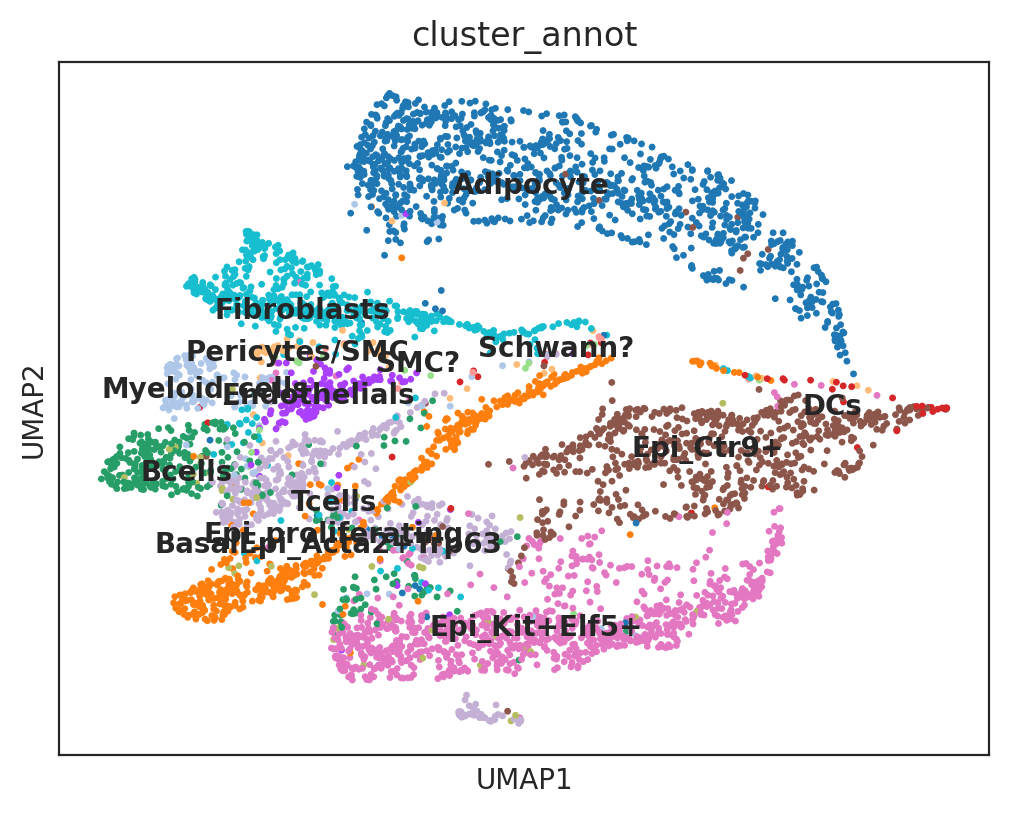

In [11]:
# Visualize UMAP with clusters
sc.pl.umap(adata, color='cluster_annot', legend_loc='on data')

## 1.5. Load base-GRN data

In [12]:
# Load TF info
# For mouse:
base_GRN = co.data.load_mouse_promoter_base_GRN()

# Check data
base_GRN.head()

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahctf1,Ahr,Ahrr,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100014821_100015921,Kitl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100334676_100335776,Gm4301,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_100339838_100340938,Gm4303,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100344970_100346070,Gm4302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100350091_100351191,Gm4302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Make Oracle object

In [13]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. Load gene expression data into oracle object

In [14]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.1', 'RNA_snn_res.1', 'RNA_snn_res.0.2', 'cluster_annot']
Dimensional reduction:  ['X_pca', 'X_umap']


## 2.2. Import data to Oracle

In [15]:
# Import data
oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cluster_annot",
    embedding_name="X_umap"  # Or "X_pca" if no UMAP
)

## 2.3. Import TF info

In [16]:
# Import TF data
oracle.import_TF_data(TF_info_matrix=base_GRN)

# 3. KNN imputation
## 3.1. Perform PCA

In [17]:
# Perform PCA
oracle.perform_PCA()

## 3.2. Calculate KNN

In [18]:
# Calculate neihbors (knn)
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
print(f"Selected number of PCA components: {n_comps}")

n_cell = oracle.adata.shape[0]
print(f'cell number is :{n_cell}')

k = int(0.025*n_cell)
print(f"KNN: {k}")

oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)

Selected number of PCA components: 19
cell number is :4981
KNN: 124


# 4. GRN calculation
## 4.1. Calculate GRN for cluster unit

In [19]:
%%time
# Calculate GRN for each population in clustering unit
# This will calculate GRN for each cluster separately

links = oracle.get_links(
    cluster_name_for_GRN_unit="cluster_annot",  # ADJUST to match your cluster column
    alpha=10,
    verbose_level=10
)

  0%|          | 0/14 [00:00<?, ?it/s]

Inferring GRN for Adipocyte...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for BasalEpi_Acta2+Trp63...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Bcells...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for DCs...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Endothelials...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Epi_Ctr9+...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Epi_Kit+Elf5+...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Epi_proliferating...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Fibroblasts...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Myeloid_cells...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Pericytes/SMC...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for SMC?...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Schwann?...


  0%|          | 0/2335 [00:00<?, ?it/s]

Inferring GRN for Tcells...


  0%|          | 0/2335 [00:00<?, ?it/s]

CPU times: user 10min 38s, sys: 21 s, total: 10min 59s
Wall time: 13min 35s


## 4.2. Save Links object

In [20]:
# Save Links object
links.to_hdf5(file_path="celloracle_results/CTR9_WT_3000HVG.celloracle.links")

# 5. Network preprocessing
## 5.1. Filter network edges

In [21]:
# Filter links
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
print("✓ Links filtered")

✓ Links filtered


## 5.2. Degree distribution

In [22]:
plt.rcParams["figure.figsize"] = [9, 4.5]

✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Adipocyte
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_BasalEpi_Acta2+Trp63
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Bcells
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_DCs
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Endothelials
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Epi_Ctr9+
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Epi_Kit+Elf5+
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Epi_proliferating
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Fibroblasts
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Myeloid_cells
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_Pericytes/SMC
✓ Created: figures/degree_distribution/degree_dist_cluster_annot_2000_SMC?
✓ Created: figures

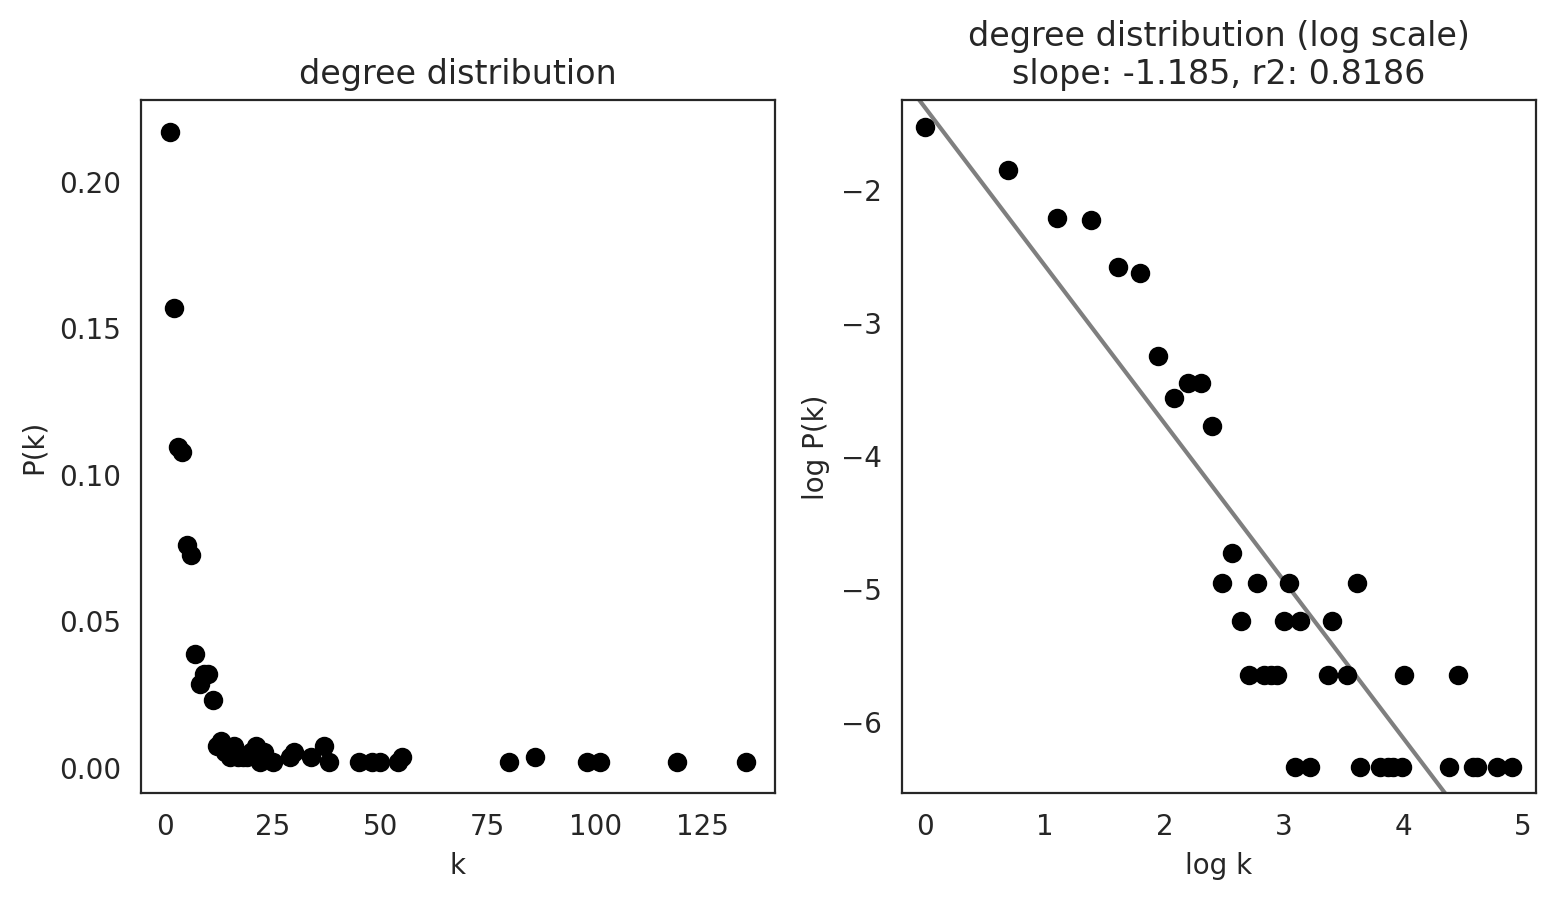

BasalEpi_Acta2+Trp63


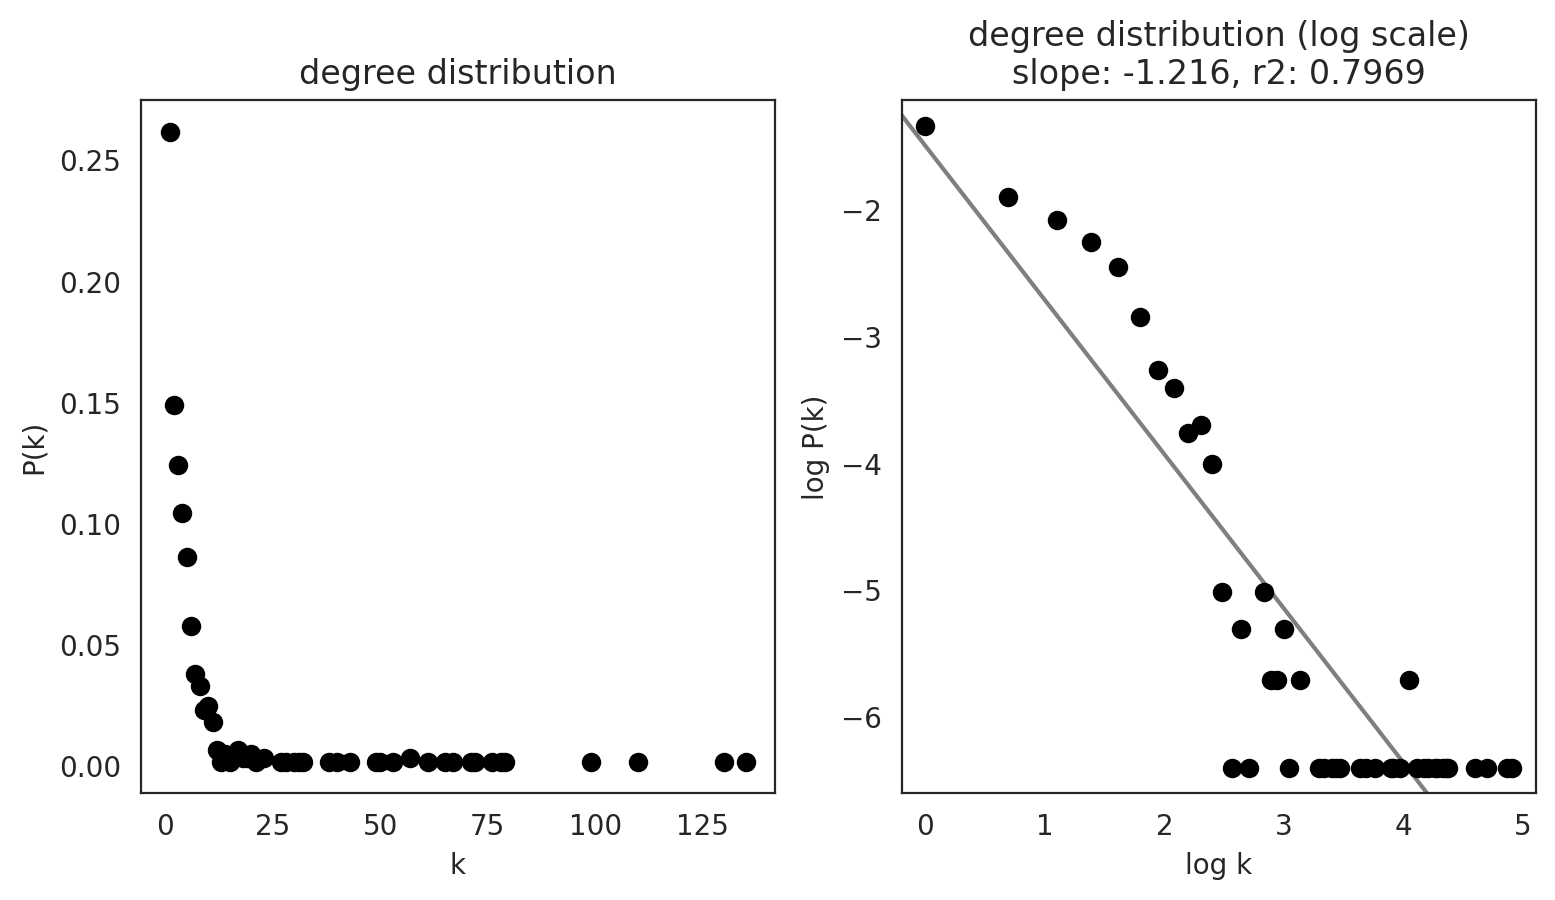

Bcells


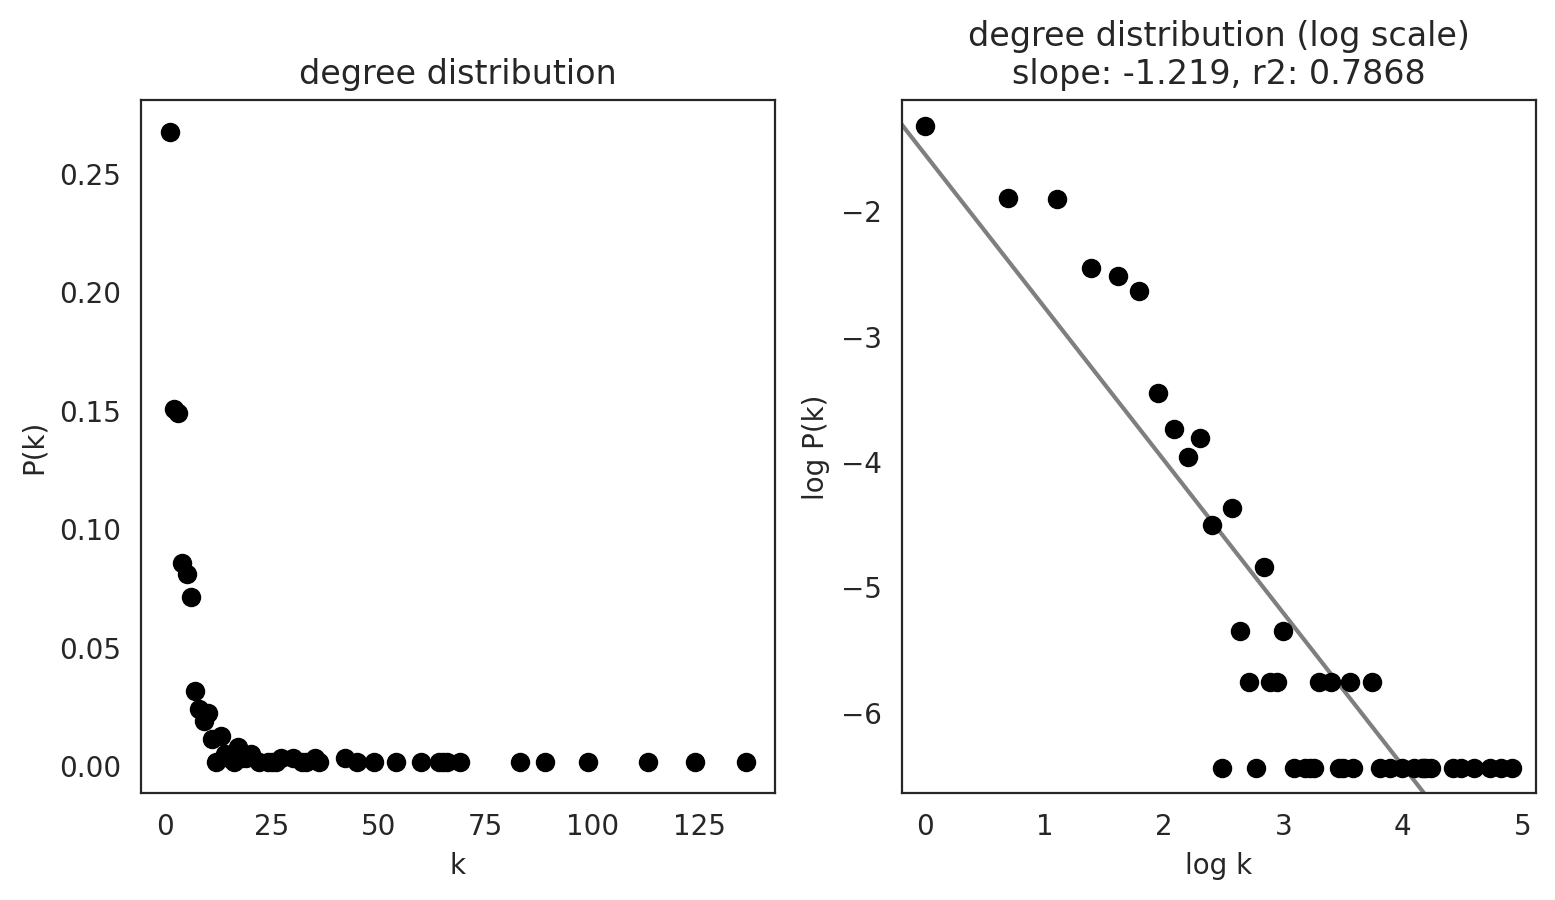

DCs


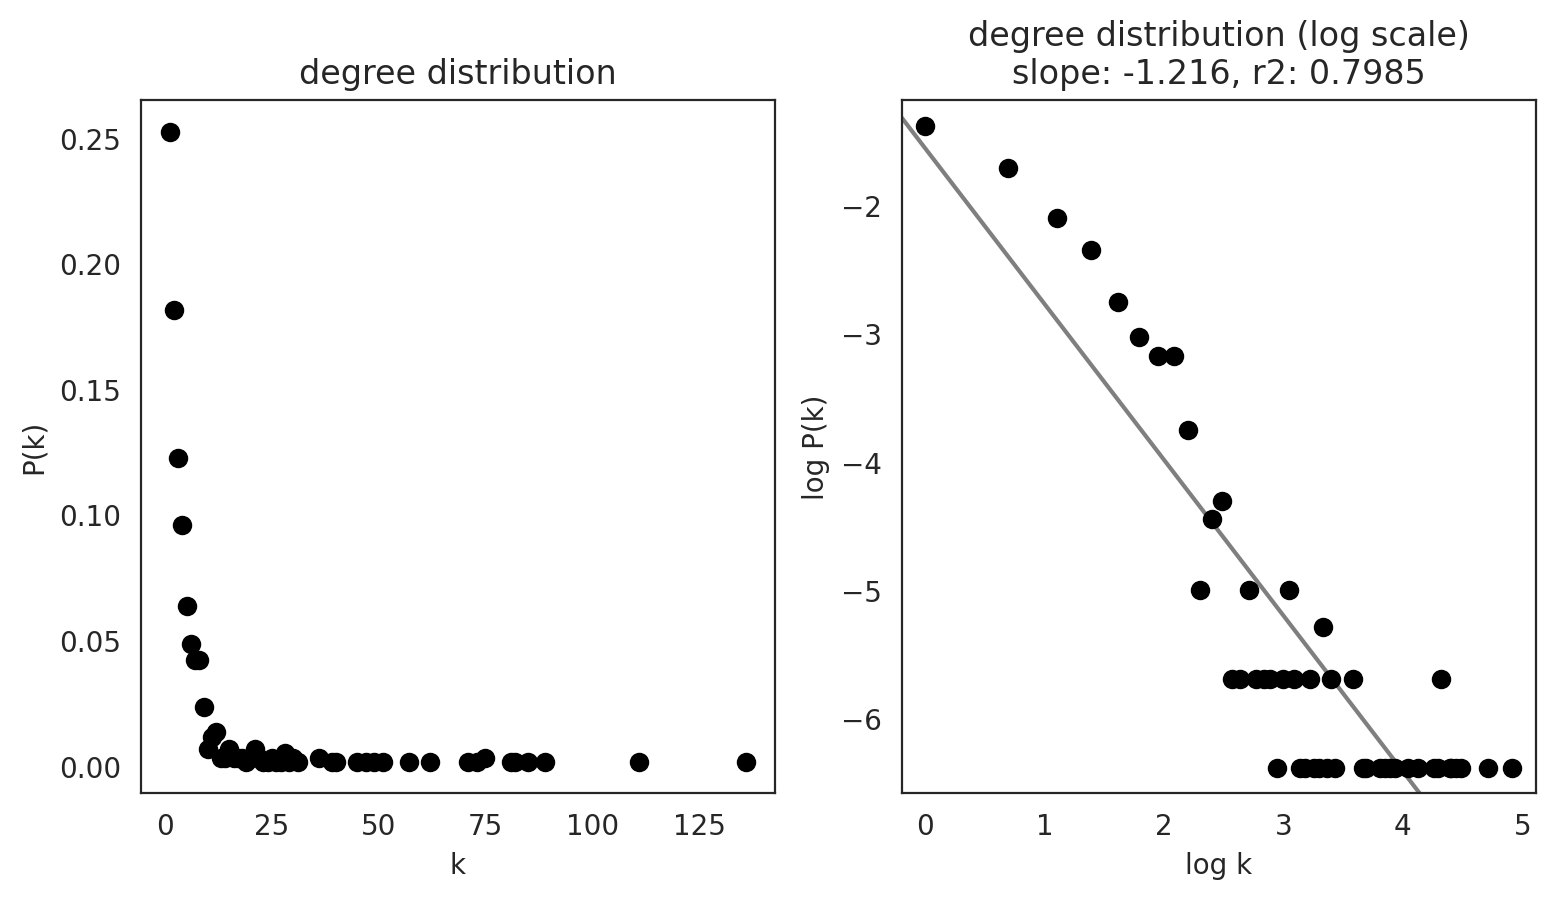

Endothelials


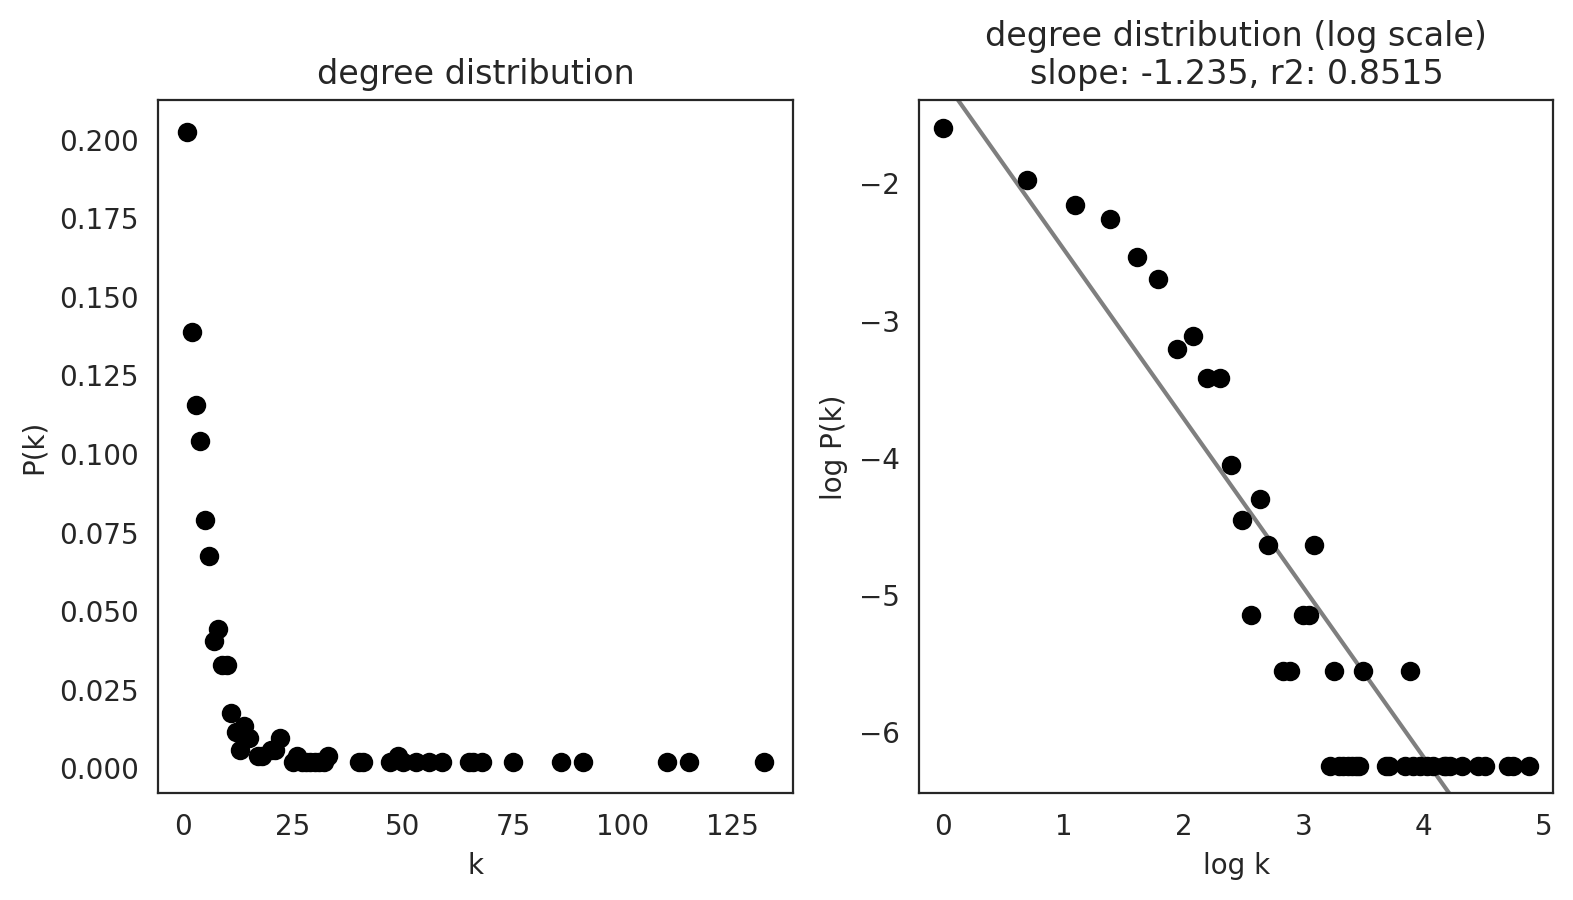

Epi_Ctr9+


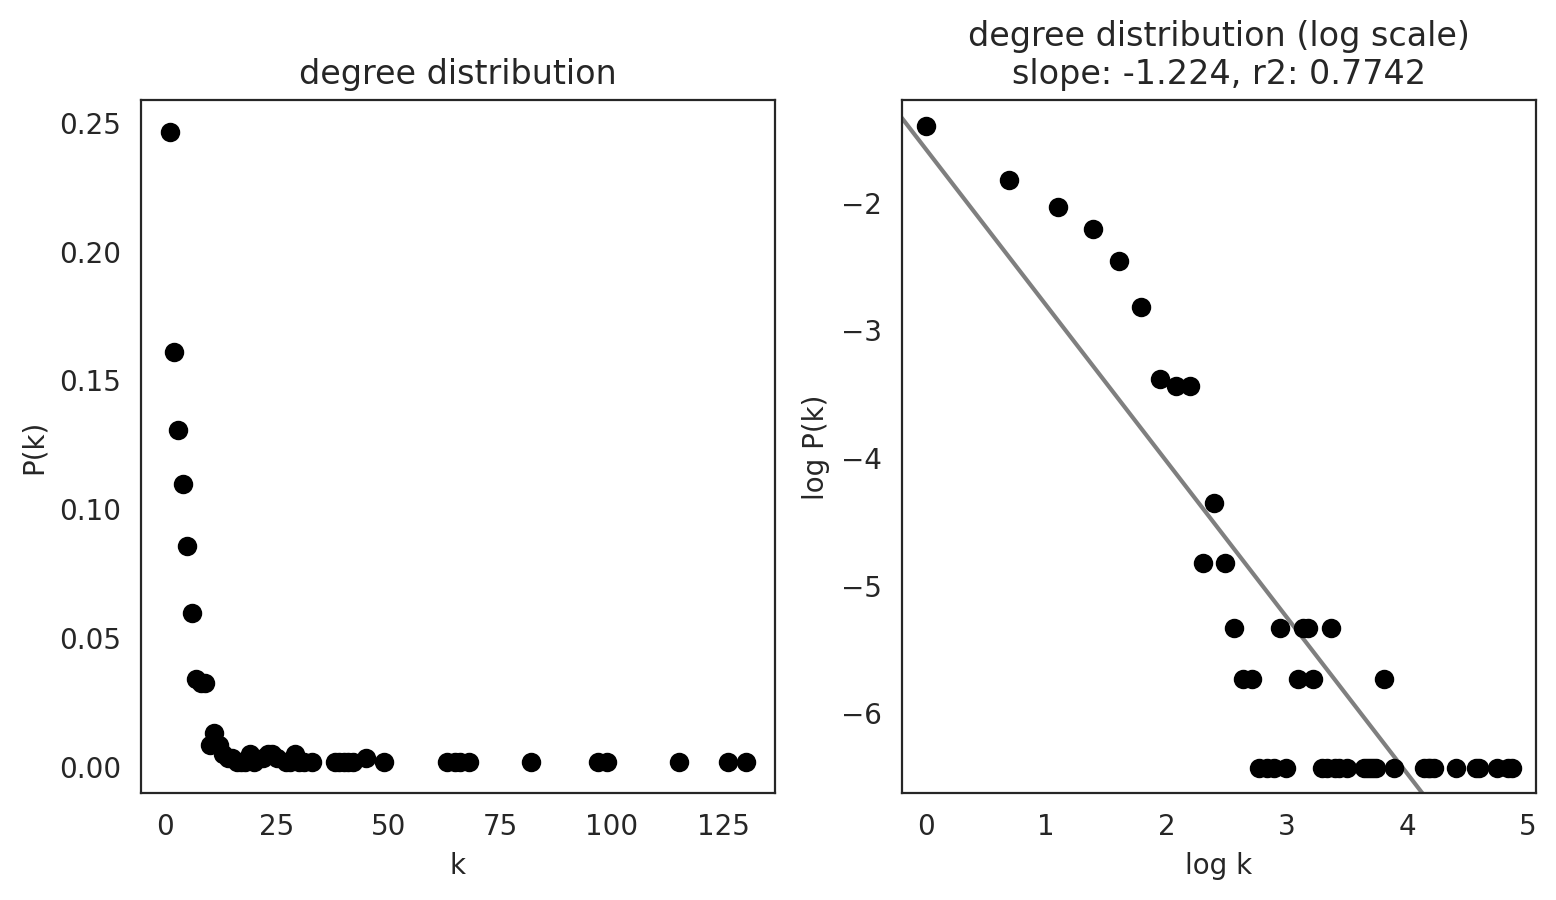

Epi_Kit+Elf5+


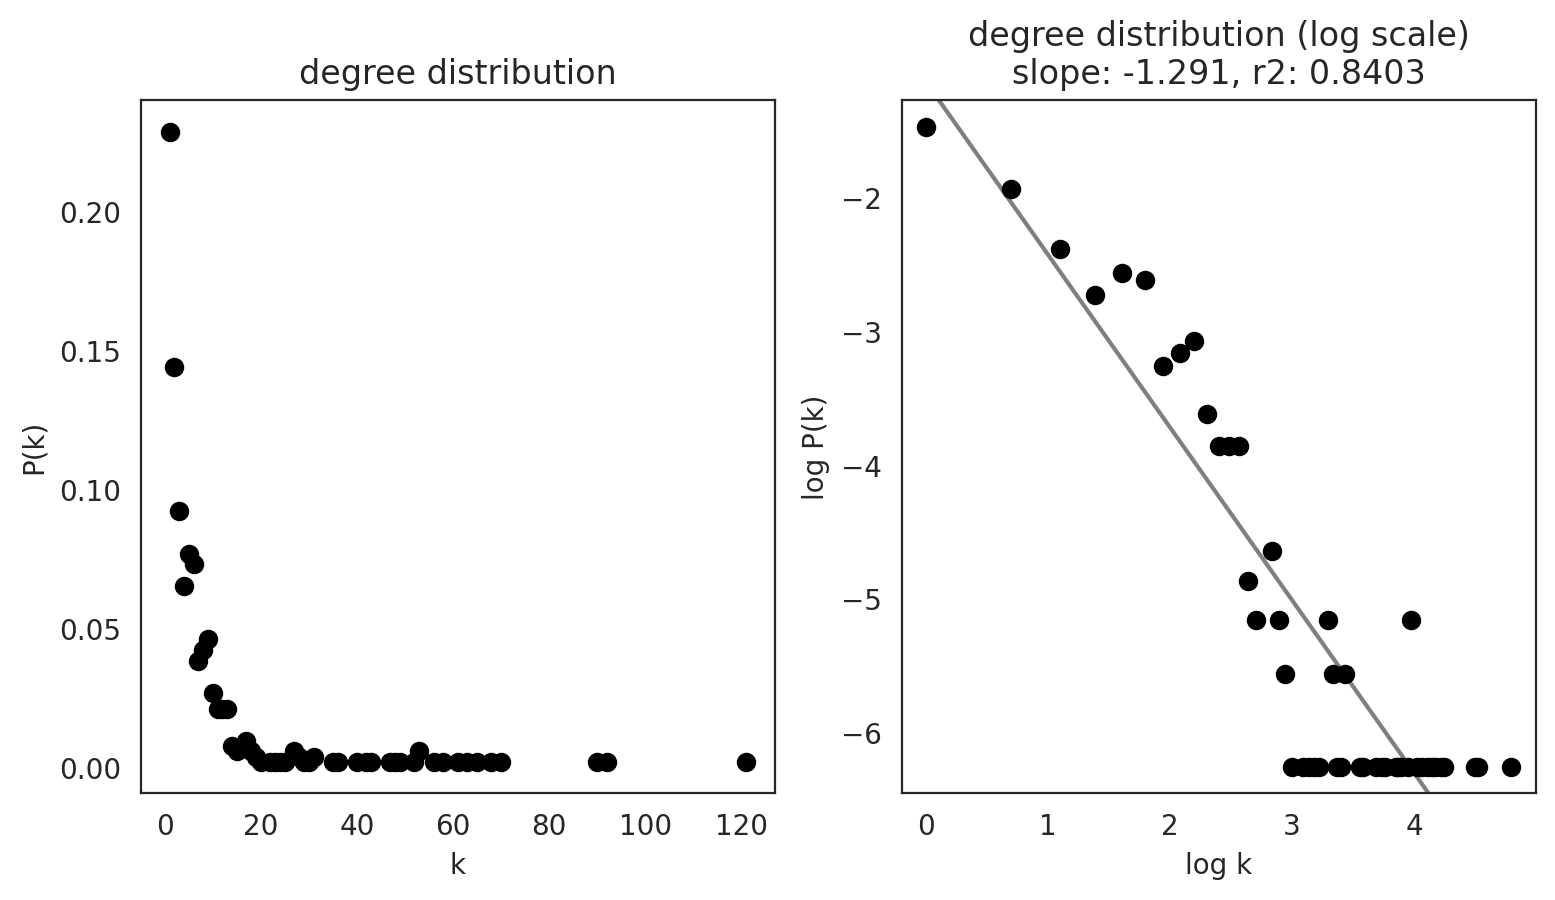

Epi_proliferating


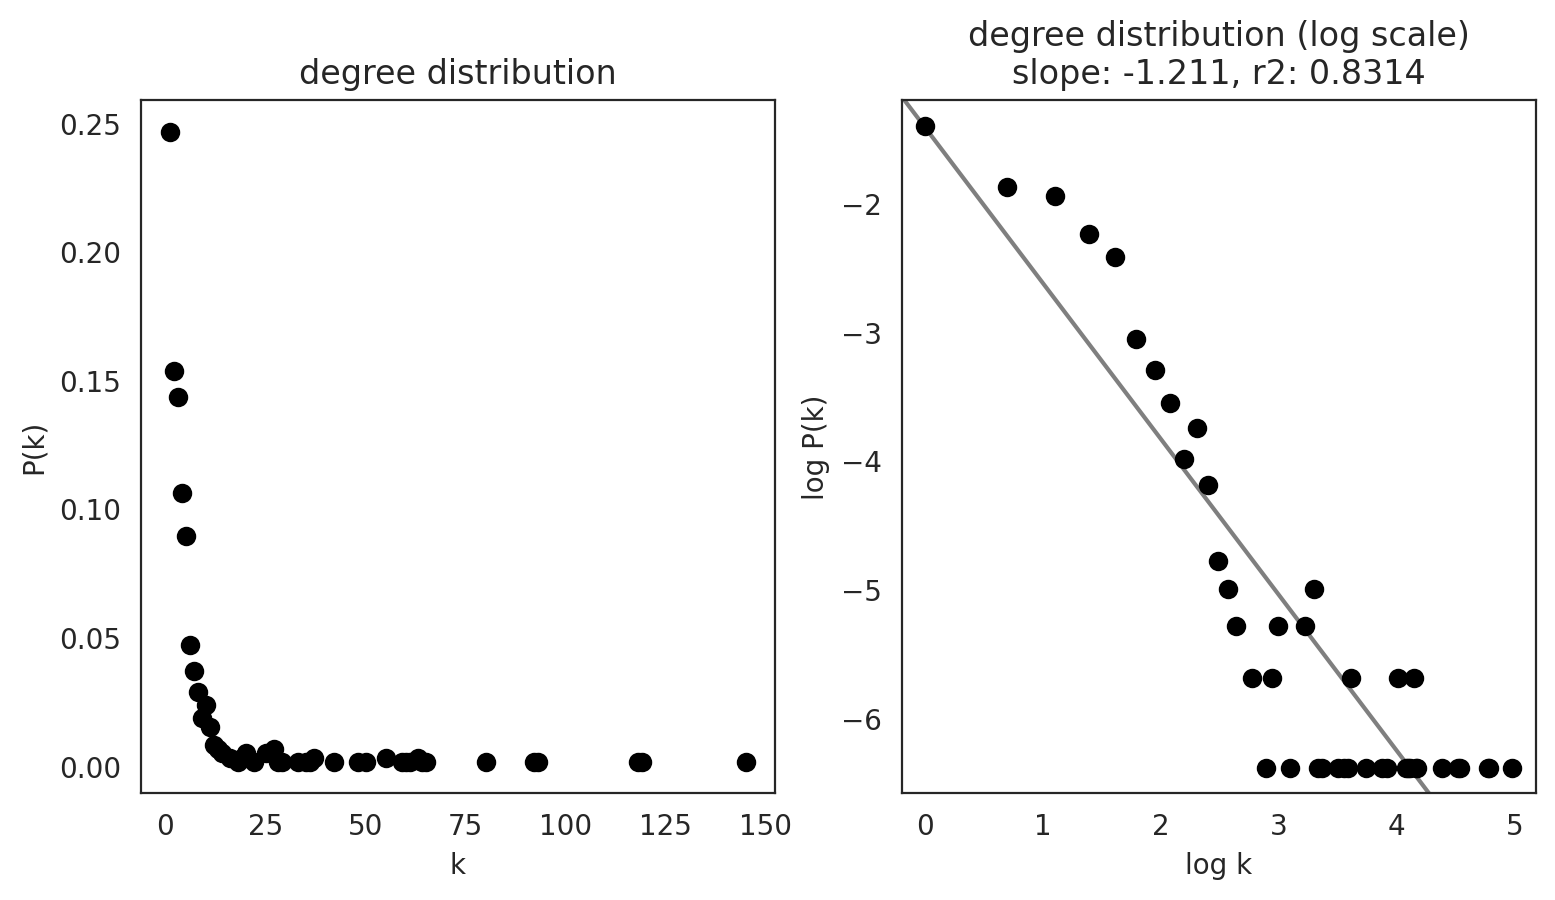

Fibroblasts


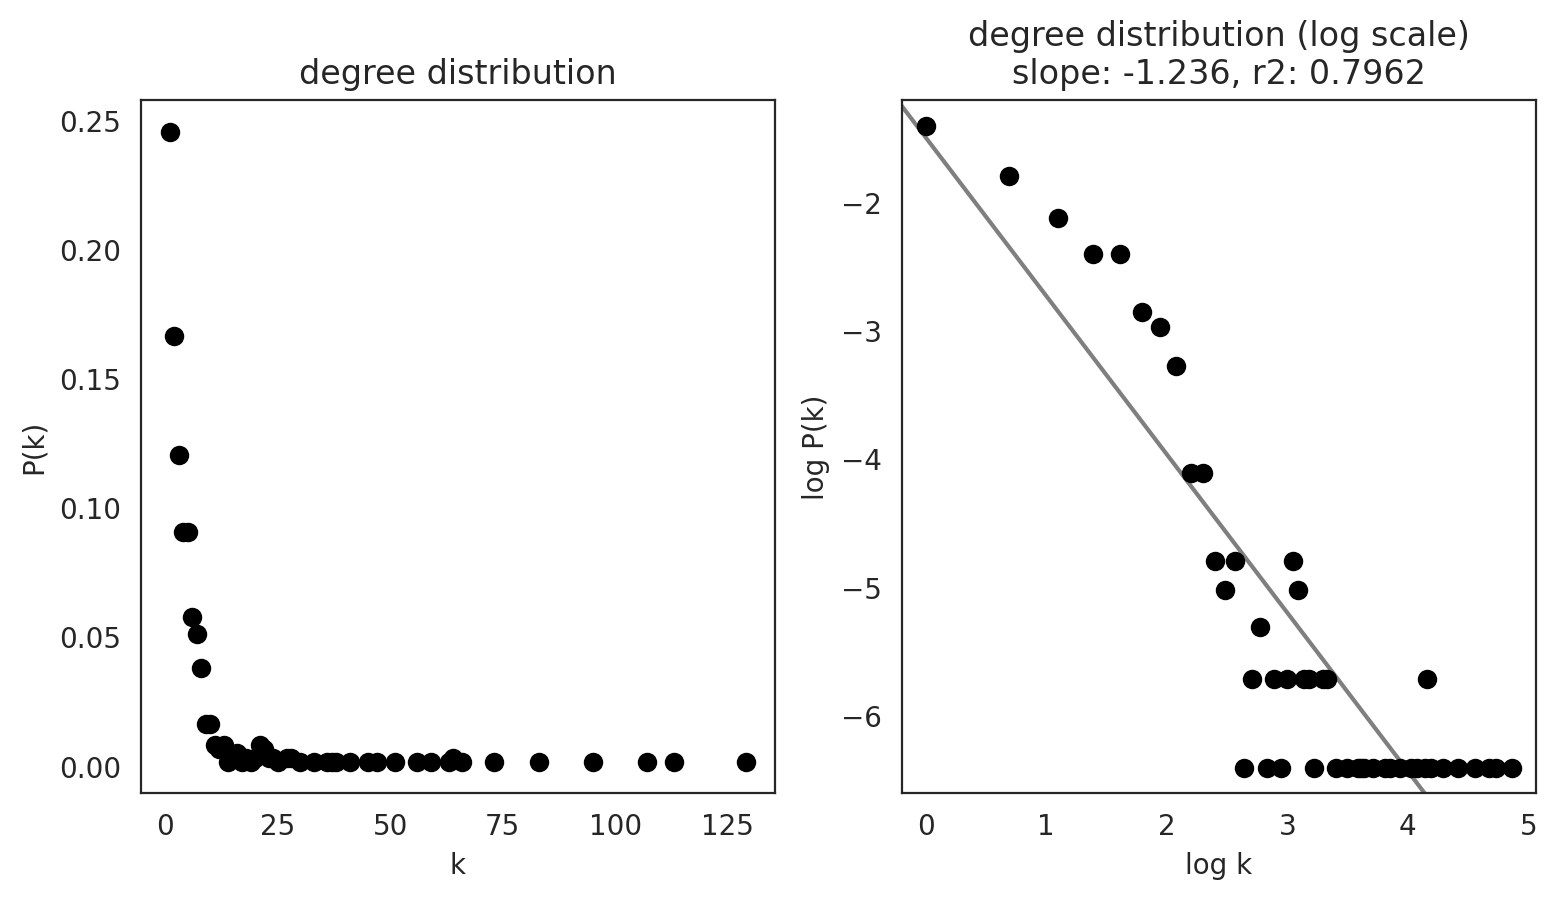

Myeloid_cells


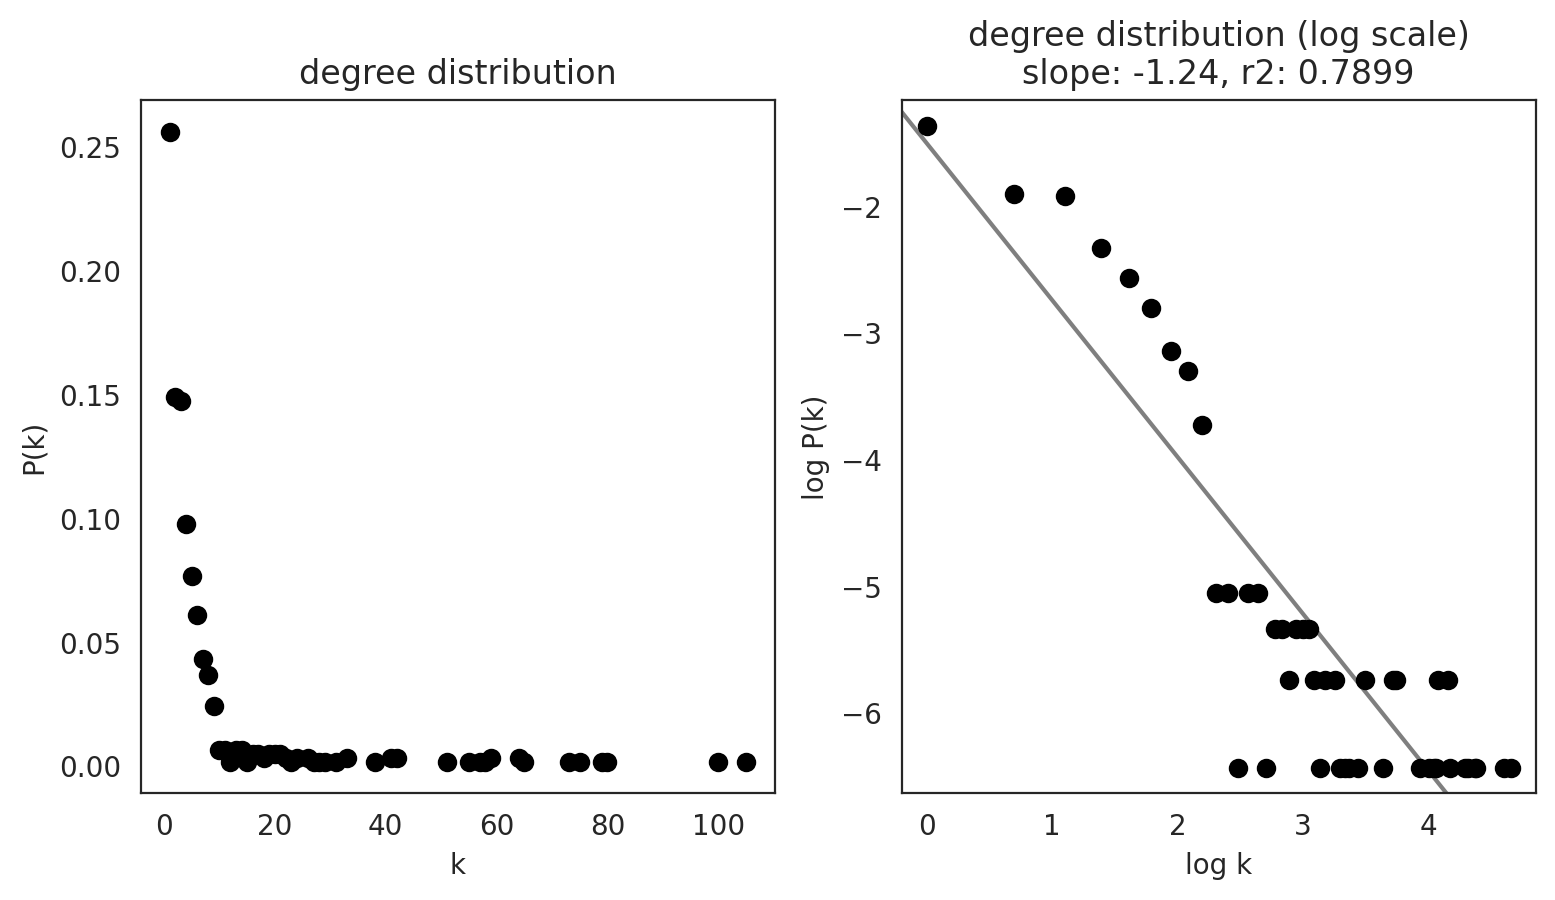

Pericytes/SMC


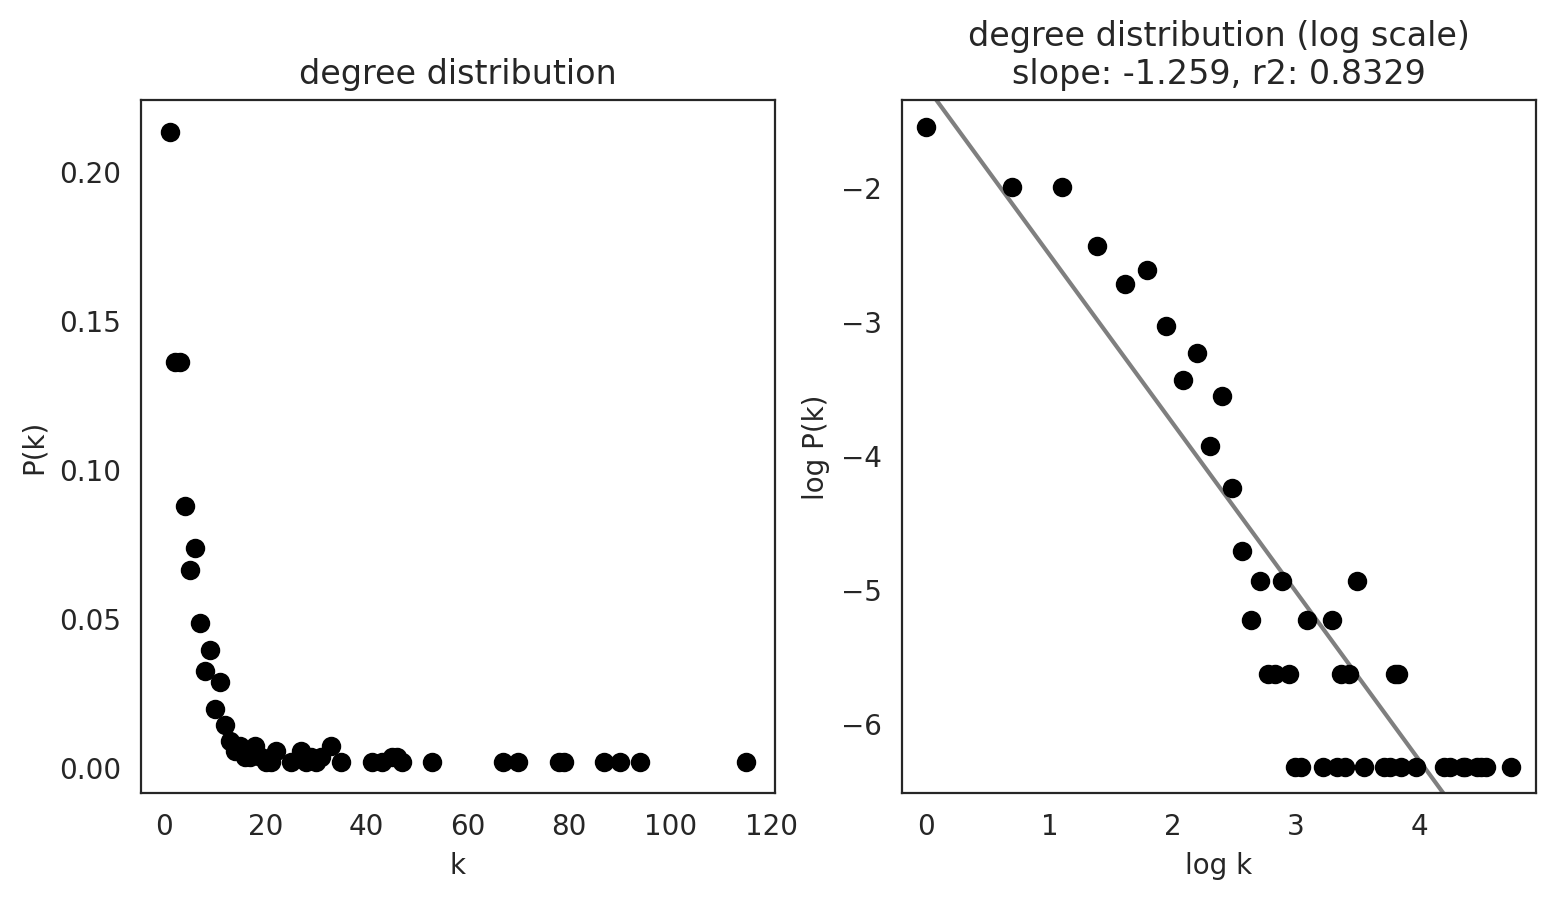

SMC?


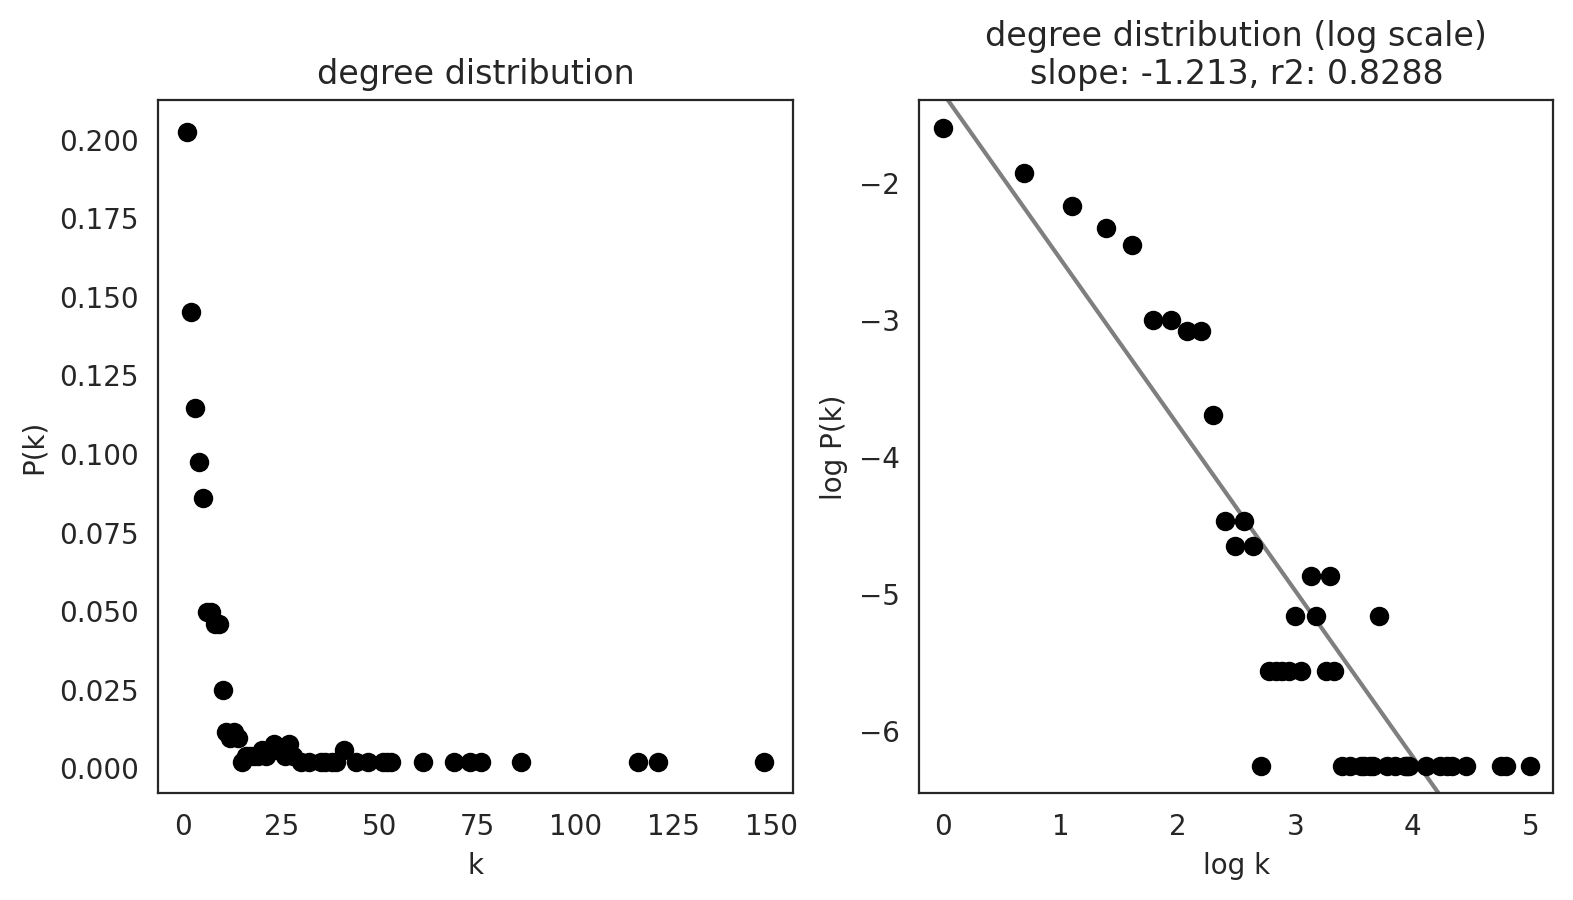

Schwann?


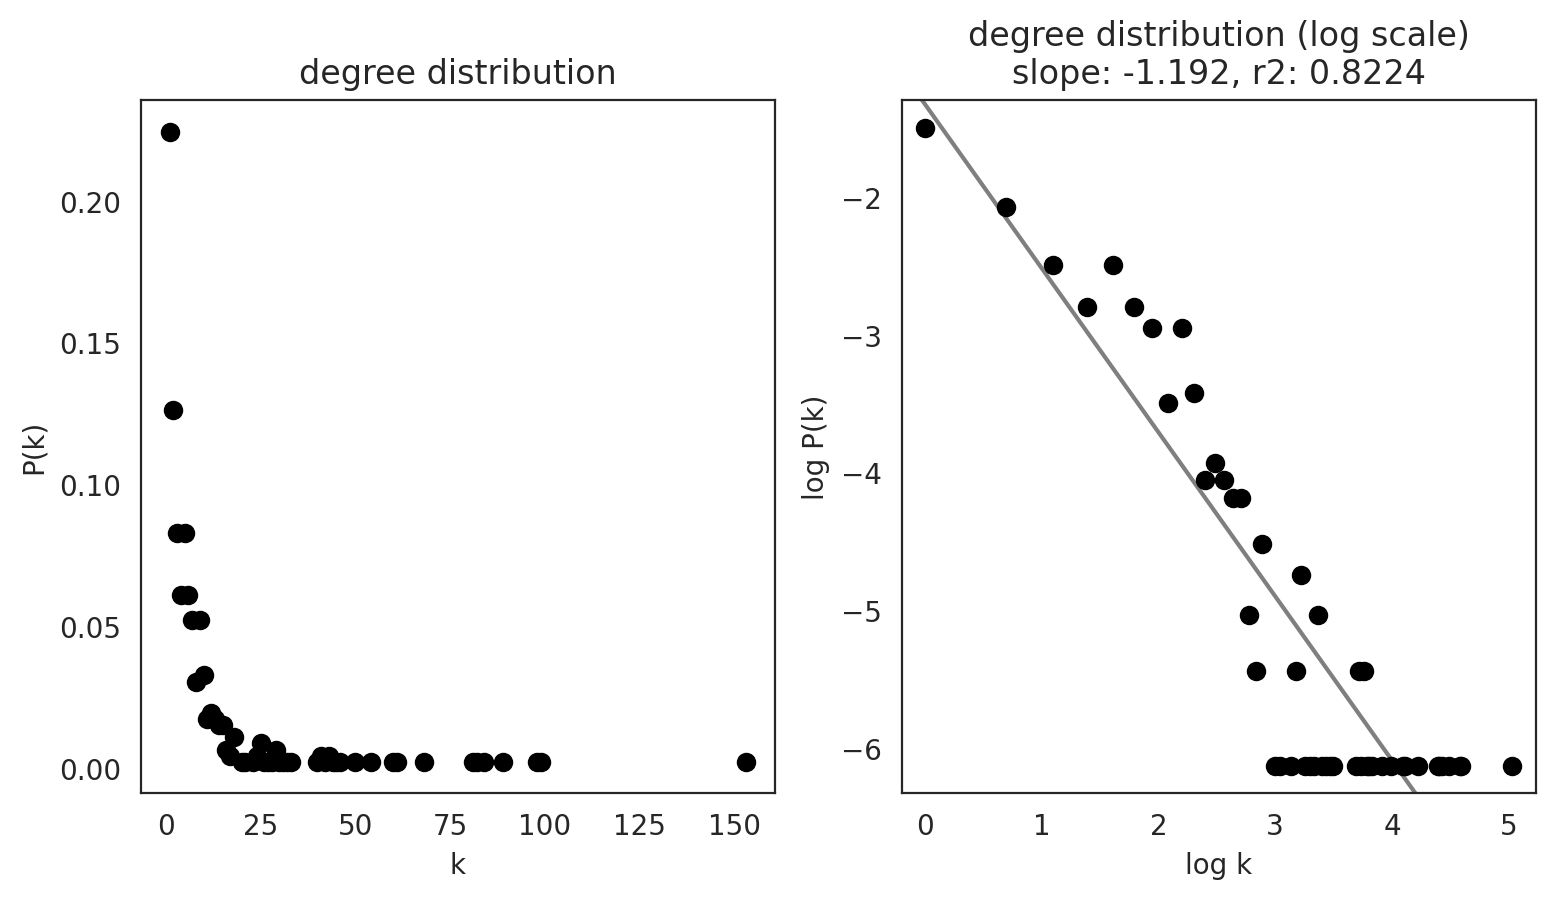

Tcells


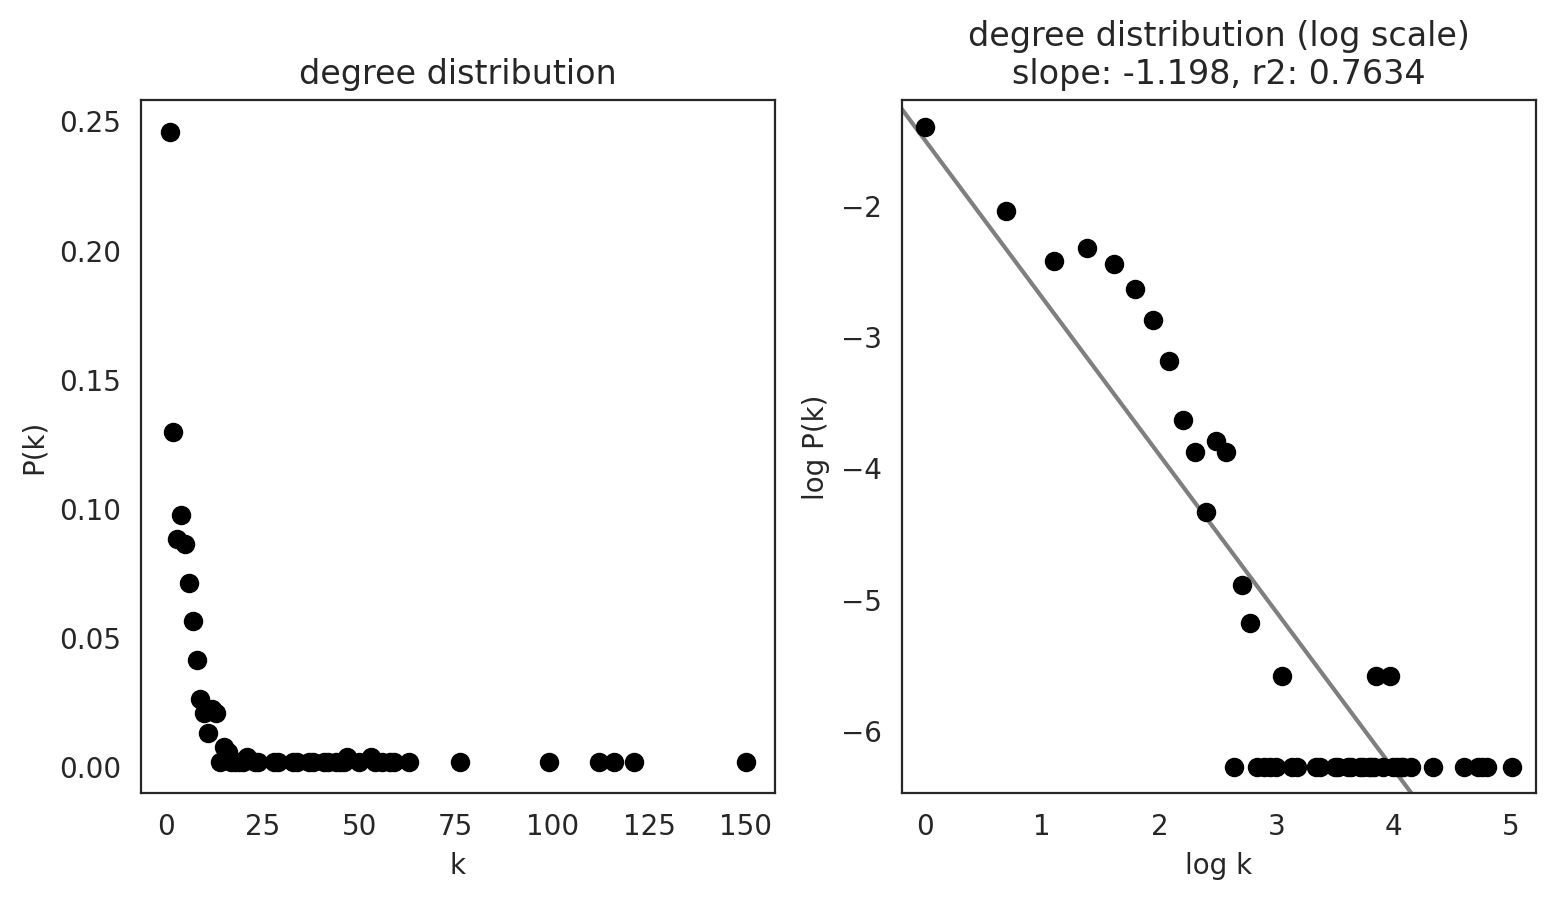

In [23]:
# Create subdirectories for each cluster (handles "/" in cluster names)
for cluster in links.cluster:
    # Create folder for this cluster
    cluster_folder = f"{save_folder}/degree_distribution/degree_dist_cluster_annot_2000_{cluster}"
    os.makedirs(cluster_folder, exist_ok=True)
    print(f"✓ Created: {cluster_folder}")

# Now plot degree distributions
links.plot_degree_distributions(
    plot_model=True,
    save=f"{save_folder}/degree_distribution/"
)

In [24]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 5.3. Calculate network score

In [25]:
# Calculate network scores
links.get_network_score()
print("✓ Network scores calculated")

✓ Network scores calculated


In [26]:
# View merged scores
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Tcf15,16,0.028269,0,0.000000,16,0.028269,0.0,0.070807,Adipocyte
B3galt1,2,0.003534,2,0.003534,0,0.000000,0.0,0.019882,Adipocyte
Ebf1,101,0.178445,9,0.015901,92,0.162544,4028.0,1.000000,Adipocyte
Acly,11,0.019435,11,0.019435,0,0.000000,0.0,0.456650,Adipocyte
Mlxipl,30,0.053004,7,0.012367,23,0.040636,300.0,0.323685,Adipocyte


## 5.4. Save filtered and scored links

In [27]:
# Save Links object with scores
links.to_hdf5(file_path="celloracle_results/CTR9_WT_3000HVG_filtered.celloracle.links")

In [28]:
# Load files when resuming
# links = co.load_hdf5(file_path="CTR9_WT_3000HVG.celloracle.links")

# 6. Network analysis
## 6.1. Network score in each cluster

In [29]:
# Check cluster names
print("Available clusters:")
print(links.cluster)

Available clusters:
['Adipocyte', 'BasalEpi_Acta2+Trp63', 'Bcells', 'DCs', 'Endothelials', 'Epi_Ctr9+', 'Epi_Kit+Elf5+', 'Epi_proliferating', 'Fibroblasts', 'Myeloid_cells', 'Pericytes/SMC', 'SMC?', 'Schwann?', 'Tcells']


## 6.2. Save ALL genes for each cluster

In [30]:
# Save ALL genes for each cluster 
merged_scores = links.merged_score

for clust in links.cluster:
    # Replace "/" with "_" to avoid directory issues
    safe_cluster_name = clust.replace("/", "_").replace("\\", "_")
    filepath = f"genes/{safe_cluster_name}_all_genes.csv"
    
    scores = merged_scores.loc[merged_scores['cluster'] == clust]
    scoreshead = scores.sort_values('degree_centrality_all', ascending=False)
    scoreshead.to_csv(filepath)
    print(f"✓ Saved: {filepath}")

✓ Saved: genes/Adipocyte_all_genes.csv
✓ Saved: genes/BasalEpi_Acta2+Trp63_all_genes.csv
✓ Saved: genes/Bcells_all_genes.csv
✓ Saved: genes/DCs_all_genes.csv
✓ Saved: genes/Endothelials_all_genes.csv
✓ Saved: genes/Epi_Ctr9+_all_genes.csv
✓ Saved: genes/Epi_Kit+Elf5+_all_genes.csv
✓ Saved: genes/Epi_proliferating_all_genes.csv
✓ Saved: genes/Fibroblasts_all_genes.csv
✓ Saved: genes/Myeloid_cells_all_genes.csv
✓ Saved: genes/Pericytes_SMC_all_genes.csv
✓ Saved: genes/SMC?_all_genes.csv
✓ Saved: genes/Schwann?_all_genes.csv
✓ Saved: genes/Tcells_all_genes.csv


## 6.3. Visualize top genes with high scores

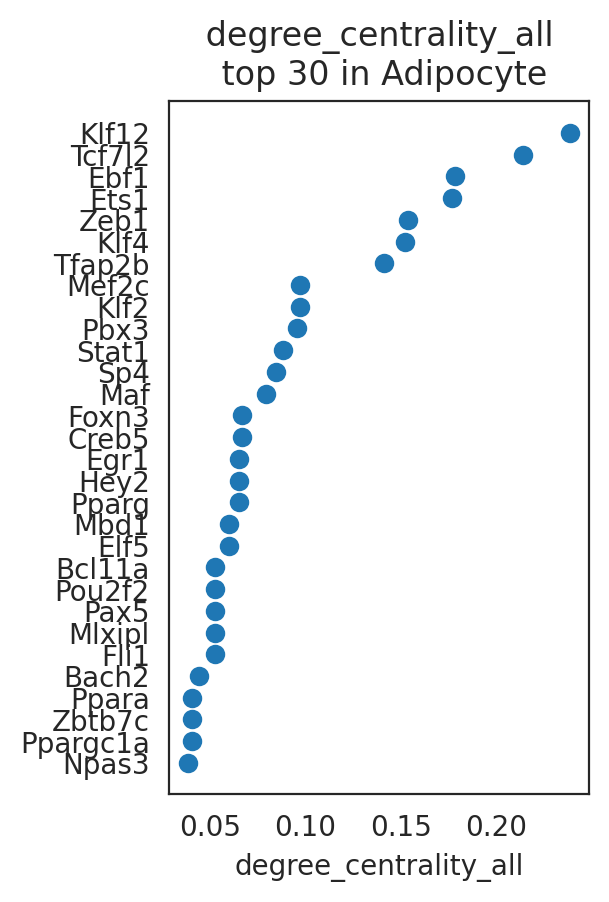

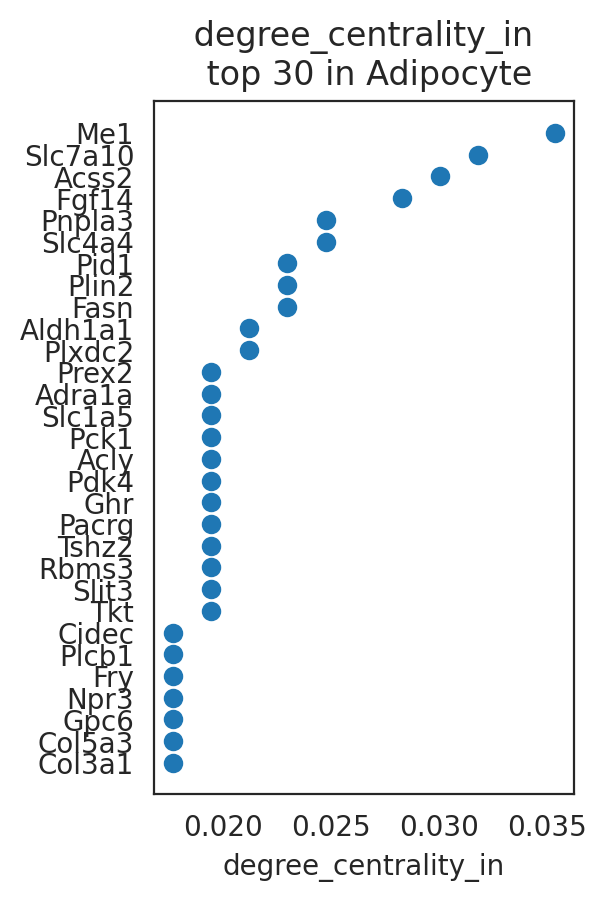

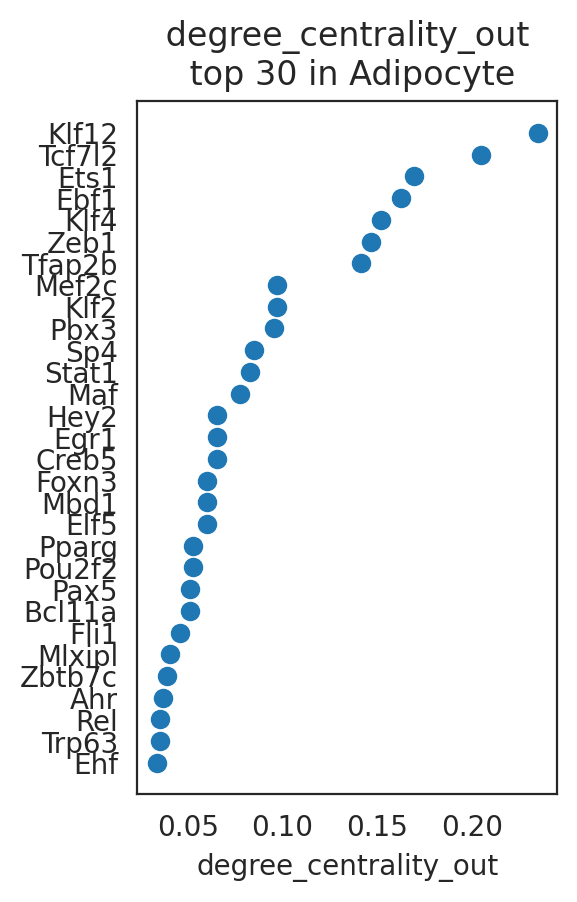

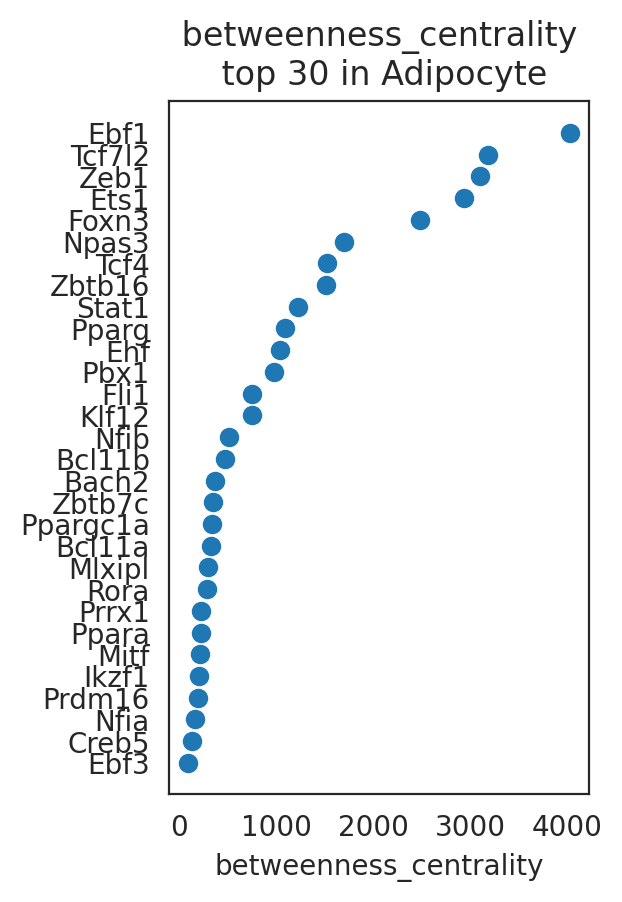

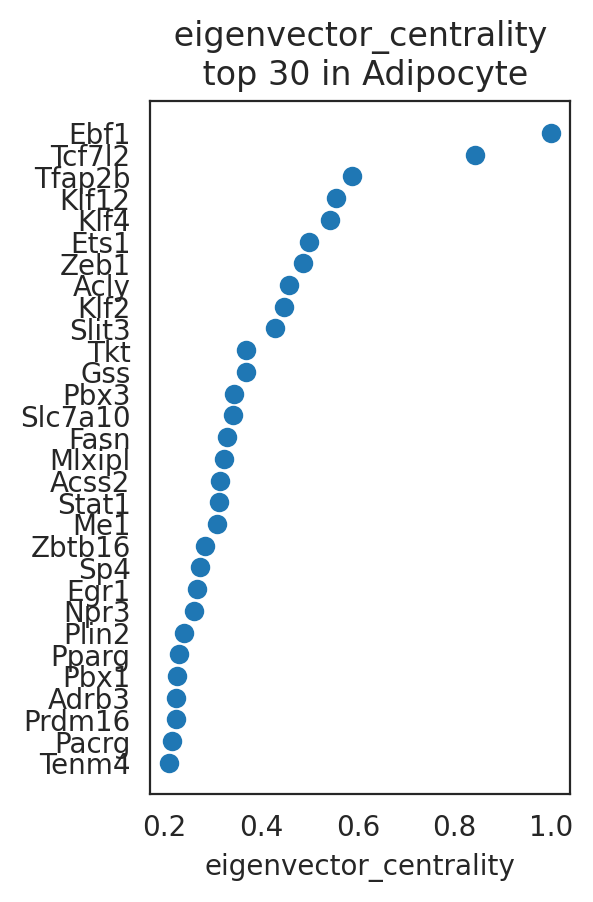

✓ Plotted top genes for Adipocyte


In [31]:
# Visualize top n-th genes with high scores for ONE cluster
# ADJUST cluster name to match your data
EXAMPLE_CLUSTER = links.cluster[0]  # Use first cluster as example

links.plot_scores_as_rank(
    cluster=EXAMPLE_CLUSTER,
    n_gene=30,
    save=f"{save_folder}/ranked_score"
)

print(f"✓ Plotted top genes for {EXAMPLE_CLUSTER}")

## 6.4. Plot top genes for ALL clusters

Plotting Adipocyte...
Plotting BasalEpi_Acta2+Trp63...
Plotting Bcells...
Plotting DCs...
Plotting Endothelials...
Plotting Epi_Ctr9+...
Plotting Epi_Kit+Elf5+...
Plotting Epi_proliferating...
Plotting Fibroblasts...
Plotting Myeloid_cells...
Plotting Pericytes/SMC...
Plotting SMC?...
Plotting Schwann?...
Plotting Tcells...


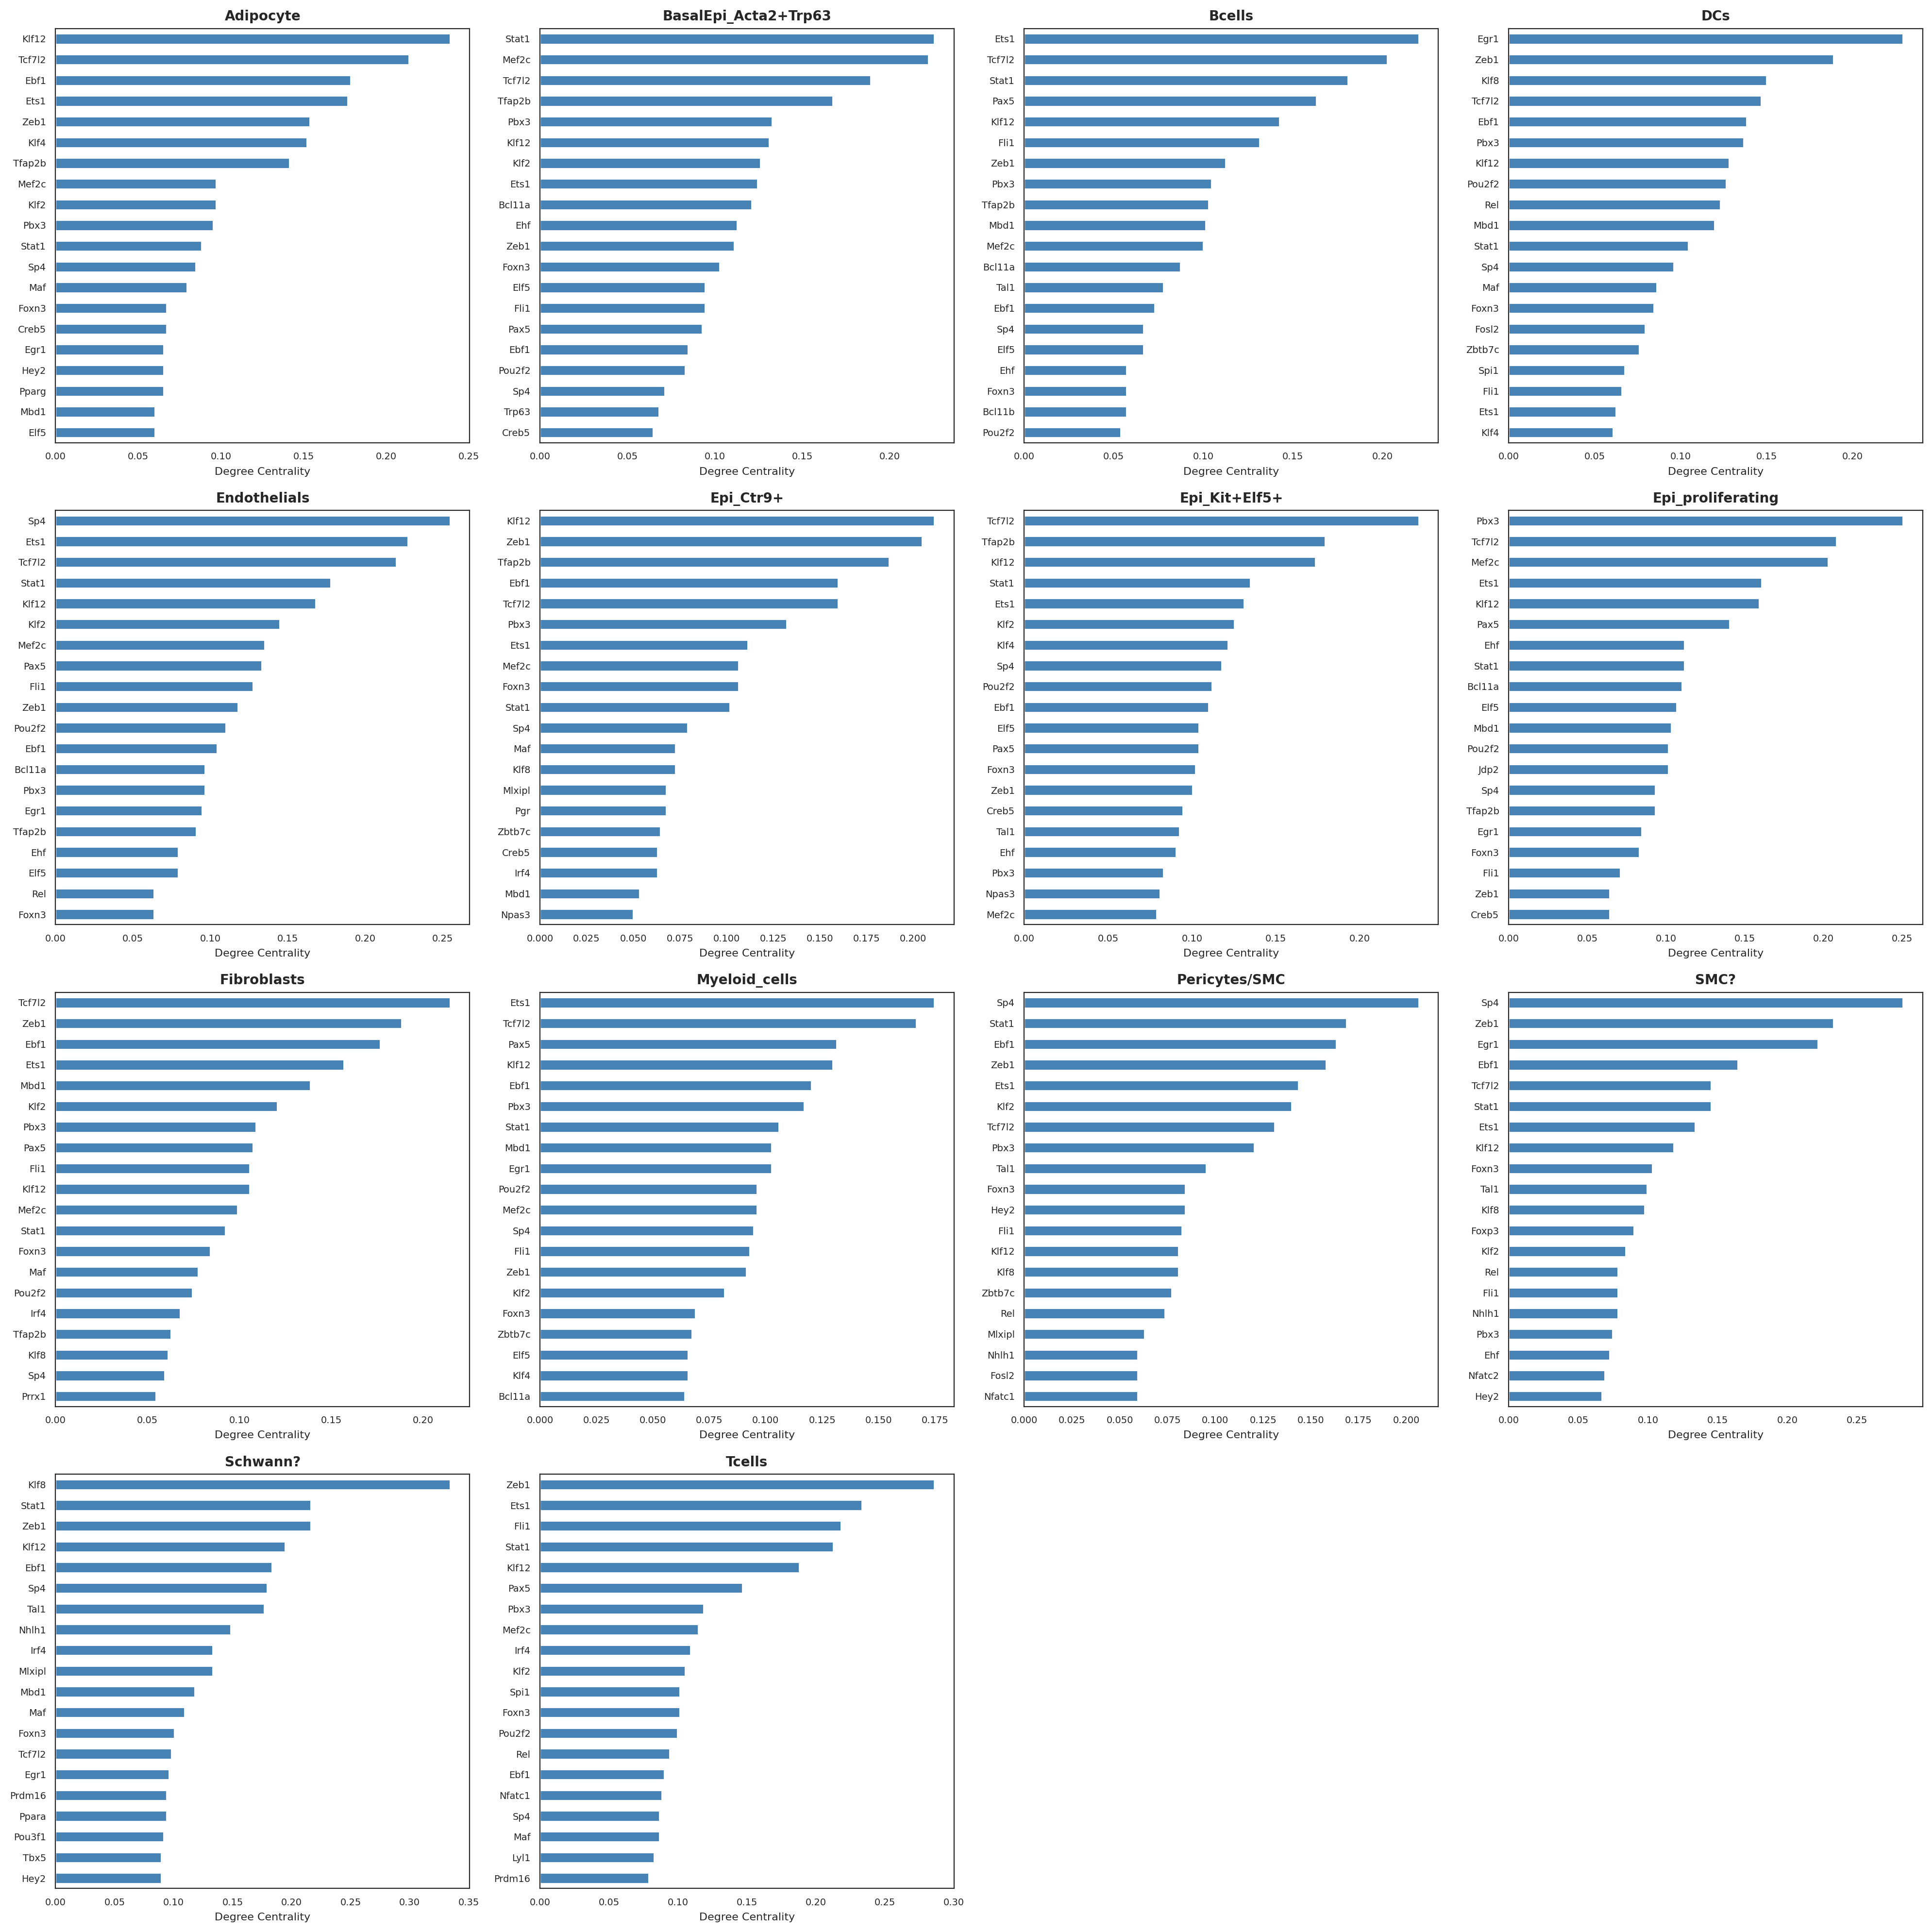

✓ Saved: figures/top_genes_all_clusters.png


In [32]:
# Create comprehensive plot of top genes across all clusters
N_TOP_GENES = 20
n_clusters = len(links.cluster)

# Calculate grid dimensions
n_cols = 4
n_rows = int(np.ceil(n_clusters / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for idx, cluster in enumerate(sorted(links.cluster)):
    print(f"Plotting {cluster}...")
    
    if idx < len(axes):
        # Get scores for this cluster
        cluster_scores = links.merged_score.loc[
            links.merged_score['cluster'] == cluster,
            'degree_centrality_all'
        ].sort_values(ascending=False).head(N_TOP_GENES)
        
        # Plot
        cluster_scores.plot(kind='barh', ax=axes[idx], color='steelblue')
        axes[idx].set_title(f'{cluster}', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Degree Centrality', fontsize=8)
        axes[idx].invert_yaxis()
        axes[idx].tick_params(labelsize=7)

# Hide unused subplots
for idx in range(n_clusters, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{save_folder}/top_genes_all_clusters.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {save_folder}/top_genes_all_clusters.png")

## 6.5. Create heatmap of network scores

Creating heatmap with 135 unique genes...


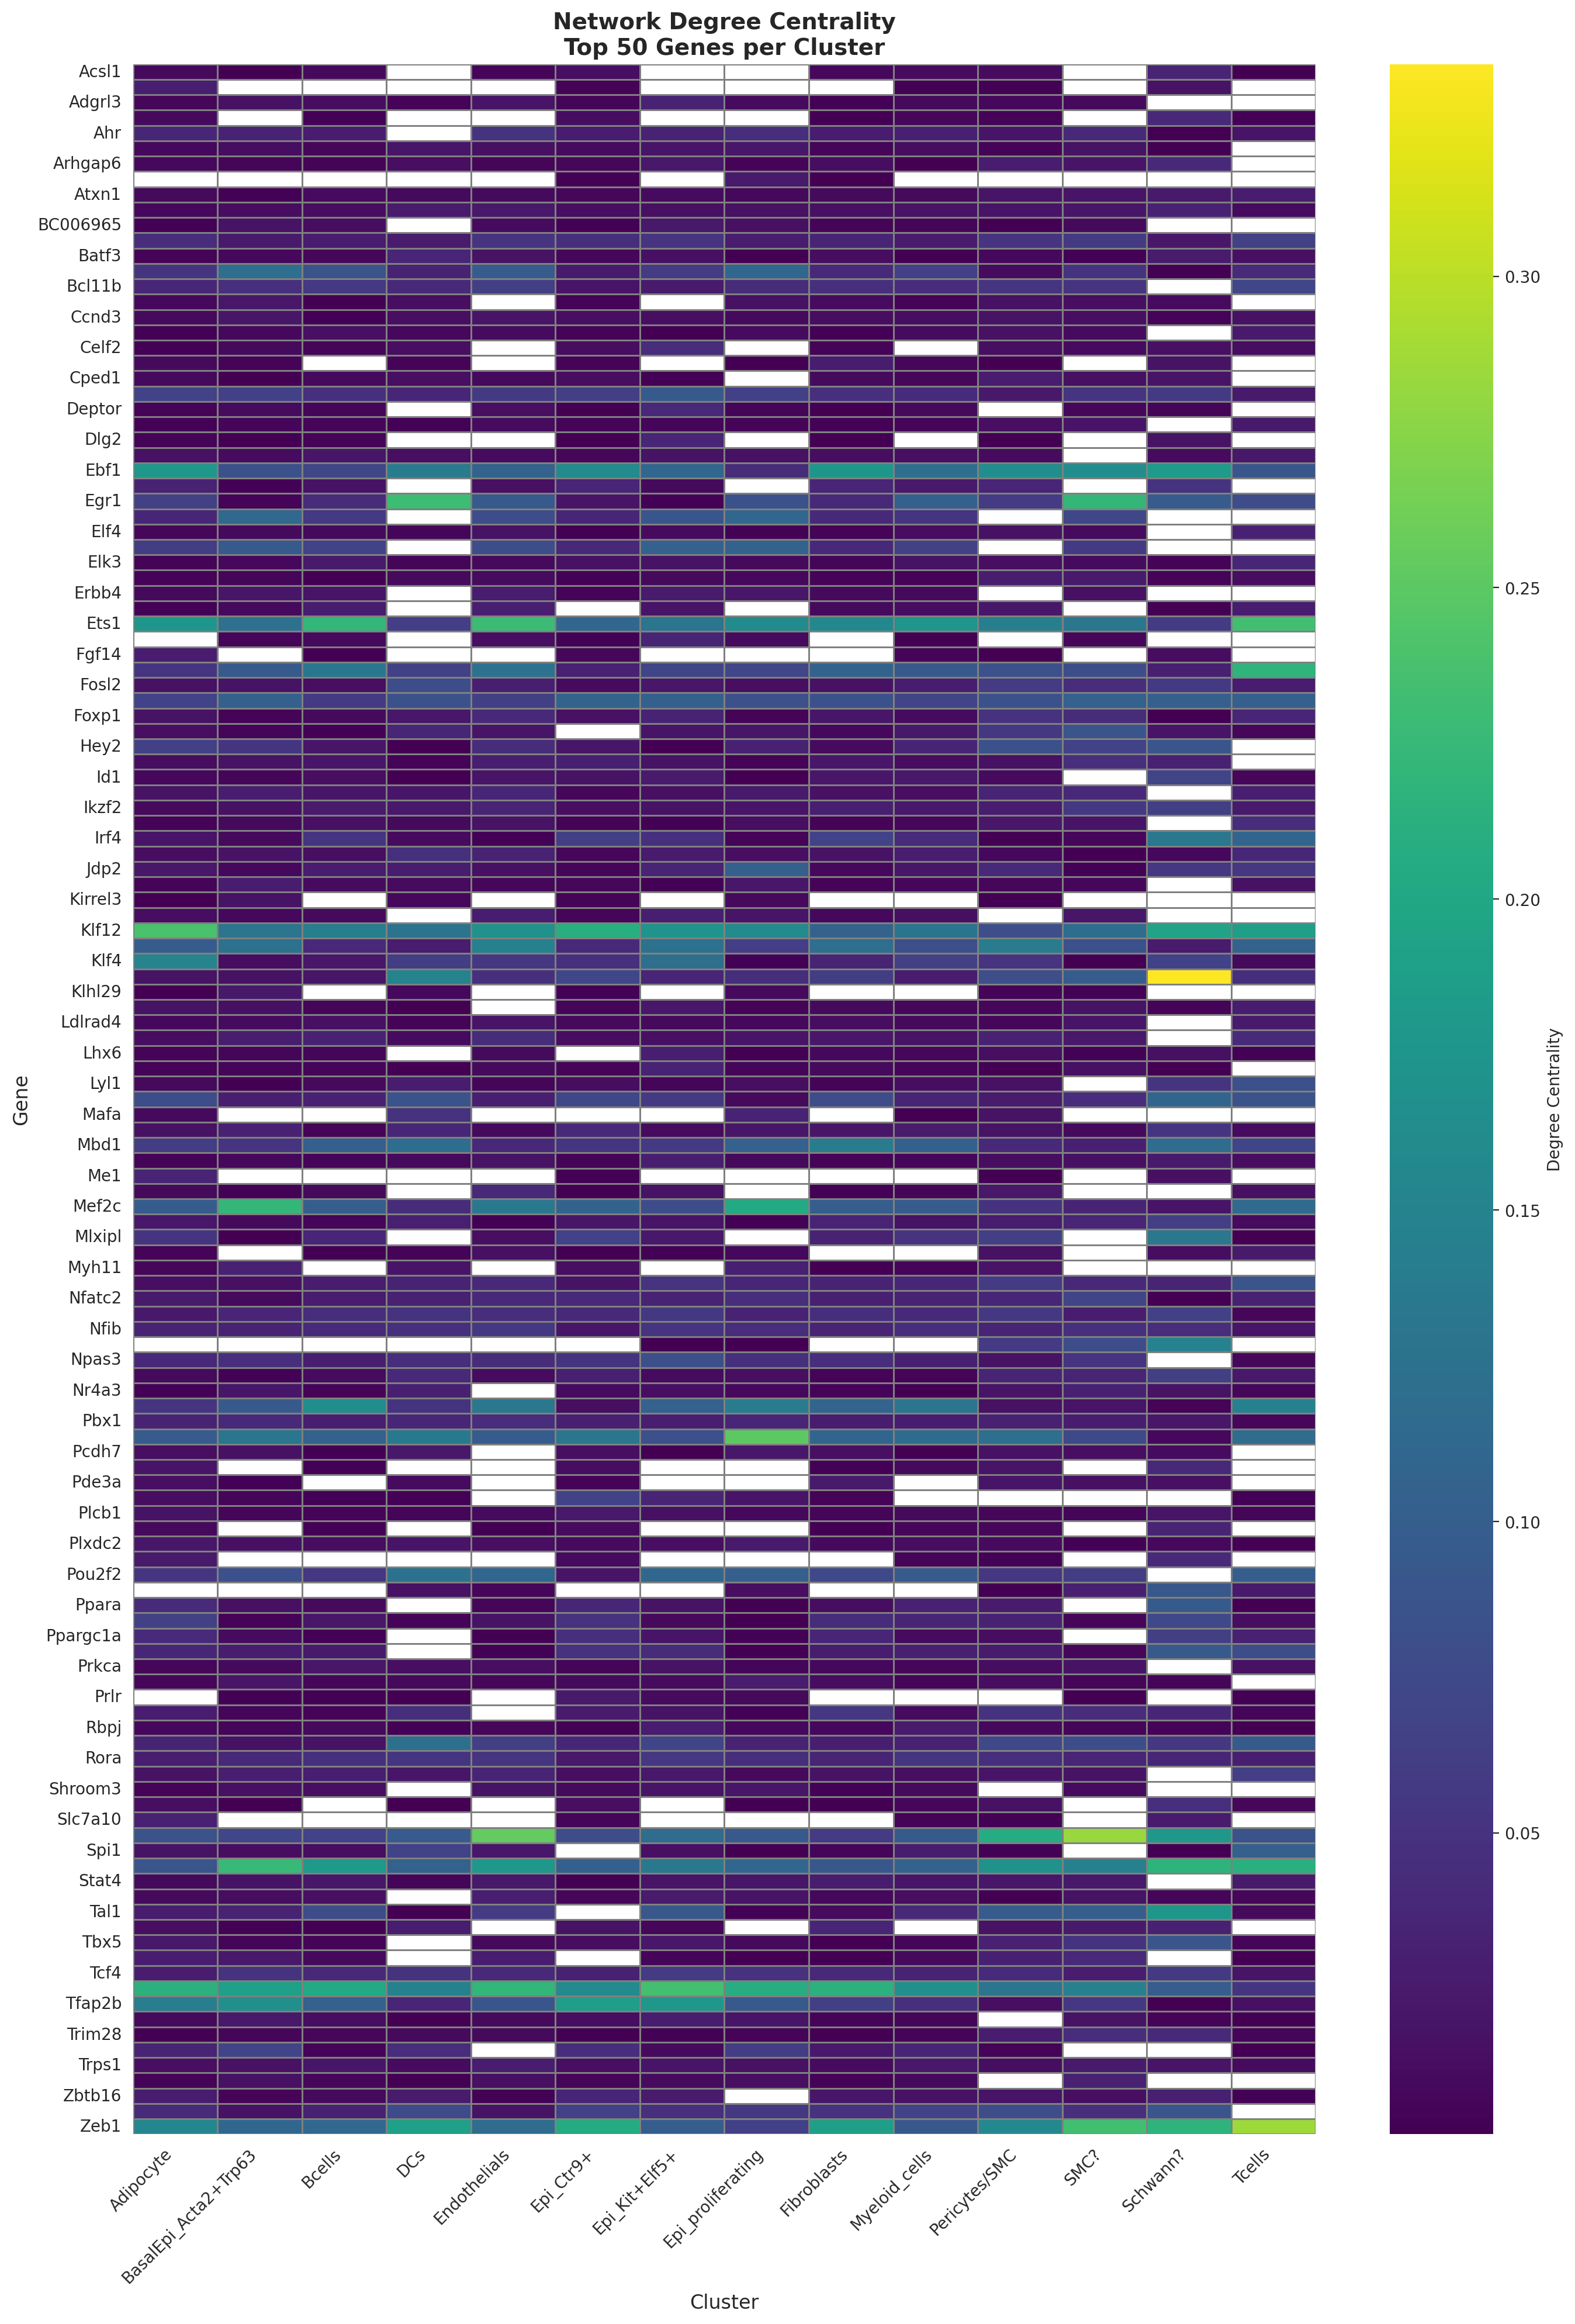

✓ Saved: figures/network_score_heatmap.png


In [33]:
# Create heatmap of network scores across clusters
N_GENES_HEATMAP = 50

# Get top genes per cluster
top_genes = set()
for cluster in links.cluster:
    cluster_mask = links.merged_score['cluster'] == cluster
    cluster_scores = links.merged_score.loc[
        cluster_mask, 'degree_centrality_all'
    ].sort_values(ascending=False)
    top_genes.update(cluster_scores.head(N_GENES_HEATMAP).index)

print(f"Creating heatmap with {len(top_genes)} unique genes...")

# Create pivot table for heatmap
score_df = links.merged_score[['cluster', 'degree_centrality_all']].copy()
score_df = score_df[score_df.index.isin(top_genes)]
pivot_table = score_df.pivot(columns='cluster', values='degree_centrality_all')

# Plot heatmap
plt.figure(figsize=(14, 20))
sns.heatmap(pivot_table, cmap='viridis', 
            cbar_kws={'label': 'Degree Centrality'},
            linewidths=0.5, linecolor='gray')
plt.title(f'Network Degree Centrality\nTop {N_GENES_HEATMAP} Genes per Cluster',
          fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Gene', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{save_folder}/network_score_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {save_folder}/network_score_heatmap.png")

## 6.6. Network score comparison between clusters

Available clusters:
0: Adipocyte
1: BasalEpi_Acta2+Trp63
2: Bcells
3: DCs
4: Endothelials
5: Epi_Ctr9+
6: Epi_Kit+Elf5+
7: Epi_proliferating
8: Fibroblasts
9: Myeloid_cells
10: Pericytes/SMC
11: SMC?
12: Schwann?
13: Tcells

Comparing Adipocyte vs BasalEpi_Acta2+Trp63


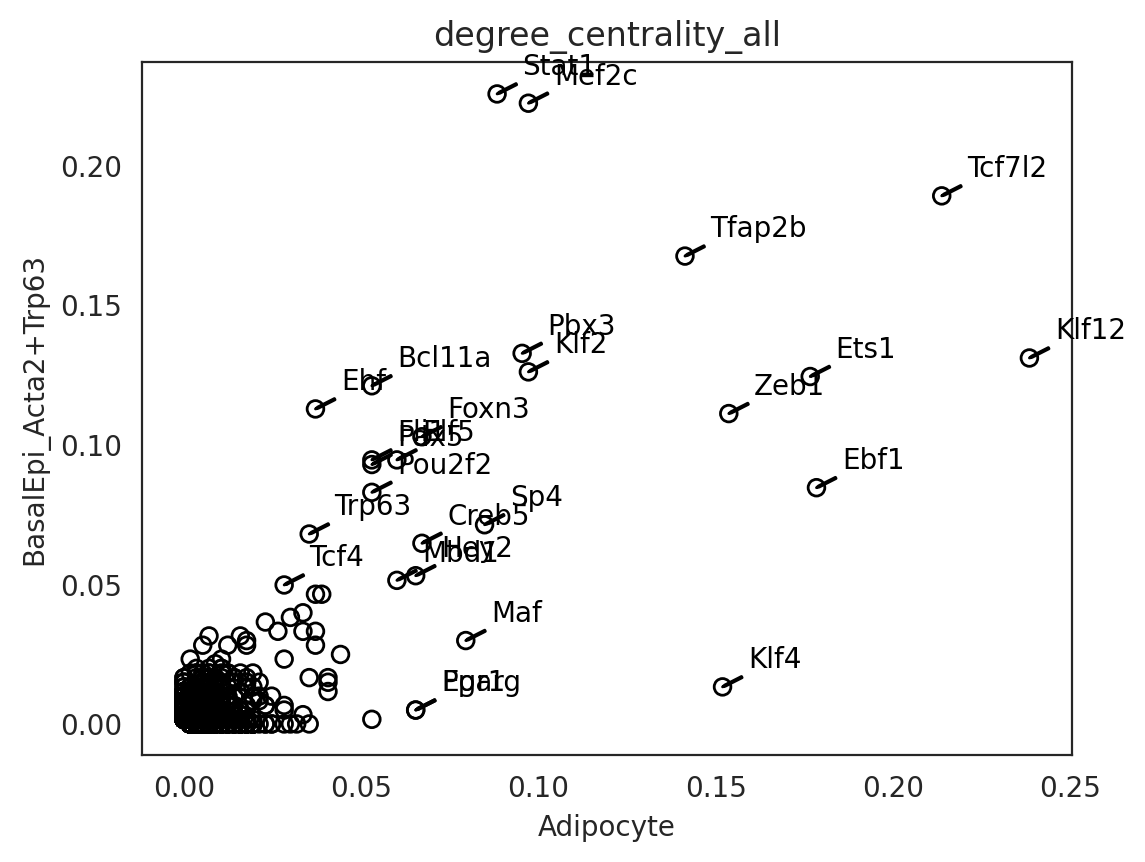

✓ Saved comparison plot to figures/score_comparison/


In [34]:
# Compare GRN score between two clusters
# ADJUST these cluster names to match your data and biological question

print("Available clusters:")
for i, clust in enumerate(links.cluster):
    print(f"{i}: {clust}")

# Select two clusters to compare
if len(links.cluster) >= 2:
    CLUSTER1 = links.cluster[0]  # Adjust index or use cluster name directly
    CLUSTER2 = links.cluster[1]  # Adjust index or use cluster name directly
    
    print(f"\nComparing {CLUSTER1} vs {CLUSTER2}")
    
    links.plot_score_comparison_2D(
        value="degree_centrality_all",
        cluster1=CLUSTER1,
        cluster2=CLUSTER2,
        percentile=97,
        save=f"{save_folder}/score_comparison"
    )
    
    print(f"✓ Saved comparison plot to {save_folder}/score_comparison/")
else:
    print("Need at least 2 clusters for comparison")

## Files created:

### Links objects:
- `celloracle_results/CTR9_WT_3000HVG.celloracle.links` - Raw GRN links
- `celloracle_results/CTR9_WT_3000HVG_filtered.celloracle.links` - Filtered and scored links

### Gene rankings:
- `genes/[cluster_name]_all_genes.csv` - Complete gene rankings for each cluster
- `CTR9_WT_top_genes.zip` - Zip file of all gene rankings

### Figures:
- `figures/degree_distribution/` - Degree distribution plots
- `figures/ranked_score/` - Top genes by cluster
- `figures/score_comparison/` - Cluster comparison plots
- `figures/top_genes_all_clusters.png` - Comprehensive plot
- `figures/network_score_heatmap.png` - Cross-cluster heatmap

## Next steps:
1. Examine top genes in each cluster
2. Identify cluster-specific regulatory programs
3. Perform in silico perturbation analysis (see CellOracle documentation)
4. Simulate trajectory and GRN dynamics
